In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import math

from votekit.ballot import Ballot
from fractions import Fraction
# from votekit.pref_profile import PreferenceProfile

from votekit.plots import plot_summary_stats
import votekit.ballot_generator as bg

from votekit.graphs import PairwiseComparisonGraph
from votekit.elections import Plurality, DominatingSets, IRV 

In [148]:
# Helper Functions

def softmax(x, temperature=1.0):
    e_x = np.exp((x - np.max(x)) / temperature)  # Subtract max for numerical stability and divide by temperature
    return e_x / e_x.sum()

def distances_to_probabilities(distances_dict, temperature=1.0):
    # Extract the values and convert them to a list
    values_list = list(distances_dict.values())
    
    # Convert the list to a NumPy array
    values_array = np.array(values_list)
    
    # Apply the softmax function to the negated distances with temperature
    probabilities = softmax(-values_array, temperature)  # Negate to give higher probability to smaller distances
    
    # Create a new dictionary with probabilities
    probability_distribution = {key: prob for key, prob in zip(distances_dict.keys(), probabilities)}
    
    return probability_distribution

def plot_colored_histogram(y):
    # Create a custom colormap from red to blue
    colors = [(0, 0, 1), (1, 0, 0)]  # Red to Blue
    n_bins = 100  # Number of bins

    # Create the custom colormap
    cmap = LinearSegmentedColormap.from_list("RedBlue", colors, N=n_bins)

    # Create the histogram
    n, bins, patches = plt.hist(y, bins=n_bins, edgecolor='black')

    # Normalize the data to [0, 1] for the colormap
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    col = bin_centers - min(bin_centers)
    col /= max(col)

    # Apply the colors to the histogram
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cmap(c))

    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Voters')
    plt.show()

def simulateBallot(dict_prob, l):
    """
    Simulates a ballot based on probabilites from a dictionary and the length of a ballot. We sample w/o replacement

    Example dict: 
    {'A': 0.2426514747465432,
     'B': 0.17313196855243765,
     'C': 0.2135050402872638,
     'D': 0.19728230610335315,
     'E': 0.09381626602650525,
     'F': 0.07961294428389709}
    
    We have 6 candidates, with probabilites being picked on the ballot.  
    """

    keys = list(dict_prob.keys())
    probabilities = list(dict_prob.values())

    if l > len(keys):
        raise ValueError("Number of samples requested exceeds the number of available keys.")

    # this here can be doing something weird... 
    sampled_cand = np.random.choice(keys, size=l, replace=False, p=probabilities)

    # Return as ballot format

    cast_record = [{vote} for vote in sampled_cand]
    ballot = Ballot(ranking = cast_record)
    
    return ballot

####### EDITING VOTEKIT FUNCTIONS #######

from matplotlib import pyplot as plt  # type: ignore
from votekit.pref_profile import PreferenceProfile
from votekit.utils import first_place_votes, mentions, COLOR_LIST, borda_scores

def plot_summary_stats(
    profile: PreferenceProfile, stat: str, multi_color: bool = True, title: str = ""
):
    """
    Plots histogram of election summary statistics.

    Args:
        profile (PreferenceProfile): A ``PreferenceProfile`` to visualize.
        stat (str): 'first place votes', 'mentions', or 'borda'.
        multi_color (bool, optional): If the bars should be multicolored. Defaults to True.
        title (str, optional): Title for the figure. Defaults to empty string.

    Returns:
        Figure: A ``matplotlib`` figure with the visualization.
    """
    stats = {
        "first place votes": first_place_votes,
        "mentions": mentions,
        "borda": borda_scores,
    }

    stat_func = stats[stat]
    data: dict = stat_func(profile)  # type: ignore

    if multi_color:
        colors = COLOR_LIST[: len(list(data.keys()))]
    else:
        colors = [COLOR_LIST[-1]]

    fig, ax = plt.subplots()

    candidates = sorted(profile.get_candidates(received_votes=False))
    y_data = [data[c] for c in candidates]
    
    ax.bar(candidates, y_data, color=colors, width=0.35)
    ax.set_xlabel("Candidates")
    ax.set_ylabel("Frequency")

    if title:
        ax.set_title(title)

    return fig


In [13]:
### Functions for generating ballot profiles ###

def simulateProfile(mu1 = 0.2, mu2 = 0.8, plot = False):
    """
    Simulates preference profile based on distribution of voters (bimodal)
    """
    # Simulate voter bimodal distribution 
    numberBallots = 10000
    y = []
    temperature = 0.15
    for _ in range(10000):
        p = np.random.random()
        if p < 0.4: 
            y.append(np.random.normal(mu1, 0.05))
        elif p < 0.8:
            y.append(np.random.normal(mu2, 0.05))
        else:
            y.append(np.random.uniform(mu1, mu2))

    if plot == True:
        plot_colored_histogram(y)

    candidates = {'A': 0.0, 'B': 0.2, 'C': 0.4, 'D': 0.6, 'E': 0.8, 'F': 1.0}

    distances = {}

    # Make dict of distances to candidates for each voter
    
    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points, temperature)
        distances[i] = dist_to_other_points

    # Sample from distribution of lengths 
    # Then pick ranking of candidate probabilistically based on distances

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        if lengths[i] < .25:
            dict_ballot[i] = simulateBallot(distances[i], 1)
        elif lengths[i] < .5:
            dict_ballot[i] = simulateBallot(distances[i], 2)
        elif lengths[i] < 0.75:
            dict_ballot[i] = simulateBallot(distances[i], 3)
        else:
            dict_ballot[i] = simulateBallot(distances[i], 4)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candiddates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile

def simulateProfileTwo(mu1 = 0.2, mu2 = 0.8, plot = False):
    """
    Simulates preference profile based on distribution of voters on different lengths
    """
    # Simulate voter bimodal distribution 
    numberBallots = 10000
    y = []
    temperature = 0.15
    for _ in range(10000):
        p = np.random.random()
        if p < 0.4: 
            y.append(np.random.normal(mu1, 0.05))
        elif p < 0.8:
            y.append(np.random.normal(mu2, 0.05))
        else:
            y.append(np.random.uniform(mu1, mu2))

    if plot == True:
        plot_colored_histogram(y)

    candidates = {'A': 0.0, 'B': 0.2, 'C': 0.4, 'D': 0.6, 'E': 0.8, 'F': 1.0}

    distances = {}

    # Make dict of distances to candidates for each voter
    
    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points, temperature)
        distances[i] = dist_to_other_points

    # Sample from distribution of lengths 
    # Then pick ranking of candidate probabilistically based on distances

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        if lengths[i] < .5:
            dict_ballot[i] = simulateBallot(distances[i], 1)
        else:
            dict_ballot[i] = simulateBallot(distances[i], 2)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candiddates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile

def simulateProfileThree(mu1 = 0.2, mu2 = 0.8, plot = False):
    """
    Simulates preference profile based on distribution of voters on different lengths
    """
    # Simulate voter bimodal distribution 
    numberBallots = 10000
    y = []
    temperature = 0.15
    for _ in range(10000):
        p = np.random.random()
        if p < 0.4: 
            y.append(np.random.normal(mu1, 0.05))
        elif p < 0.8:
            y.append(np.random.normal(mu2, 0.05))
        else:
            y.append(np.random.uniform(mu1, mu2))

    if plot == True:
        plot_colored_histogram(y)

    candidates = {'A': 0.0, 'B': 0.2, 'C': 0.4, 'D': 0.6, 'E': 0.8, 'F': 1.0}

    distances = {}

    # Make dict of distances to candidates for each voter
    
    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points, temperature)
        distances[i] = dist_to_other_points

    # Sample from distribution of lengths 
    # Then pick ranking of candidate probabilistically based on distances

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        if lengths[i] < .33:
            dict_ballot[i] = simulateBallot(distances[i], 1)
        elif lengths[i] < .66:
            dict_ballot[i] = simulateBallot(distances[i], 2)
        else:
            dict_ballot[i] = simulateBallot(distances[i], 3)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candiddates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile

PreferenceProfile too long, only showing 15 out of 375 rows.
  Ballots Weight
     (E,)    627
     (B,)    606
     (C,)    374
     (D,)    355
   (B, C)    301
   (E, F)    268
   (E, D)    262
   (B, A)    260
     (A,)    230
     (F,)    196
(B, A, C)    192
   (D, E)    183
(B, C, A)    179
   (C, B)    178
(E, F, D)    172


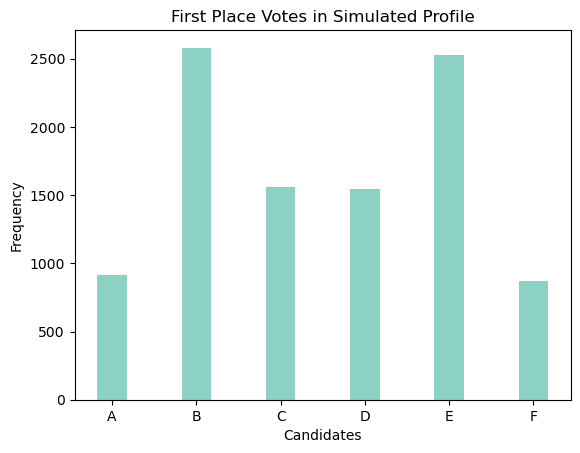

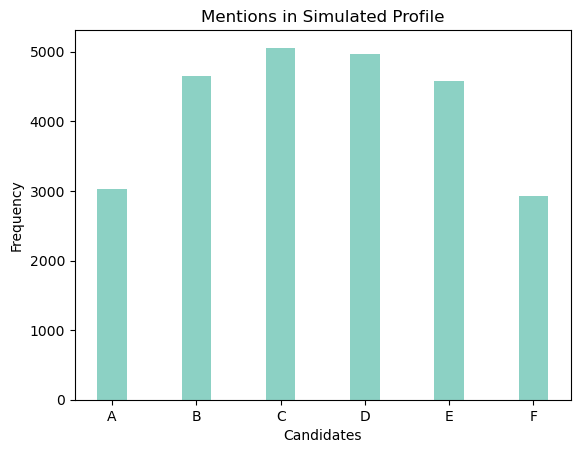

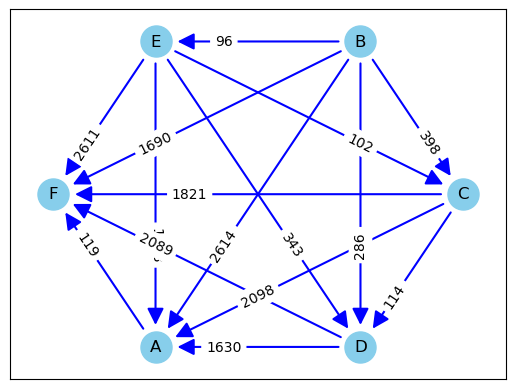

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        E Eliminated      1
        C Eliminated      1
        D Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        E Eliminated      1
        C Eliminated      1
        D Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 6
Candidate     Status  Round
        B    Elected      6
        E Eliminated      5
        C Eliminated      4
        D Eliminated      3
        A Eliminated      2
        F Eliminated      1


In [14]:
profile = simulateProfile()
print(profile)

fig1 = plot_summary_stats(profile, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
plt.show()

fig2 = plot_summary_stats(profile, "mentions", multi_color = False,
                          title = "Mentions in Simulated Profile")
plt.show()

pwc_graph = PairwiseComparisonGraph(profile)
pwc_graph.draw()
plt.show()

electionPlurality = Plurality(profile = profile,
                     seats = 1)
print(electionPlurality.run_election())

electionDominatingSets = DominatingSets(profile = profile)
print(electionDominatingSets.run_election())

electionIRV = IRV(profile = profile)
print(electionIRV.run_election())

PreferenceProfile too long, only showing 15 out of 36 rows.
Ballots Weight
   (E,)   1325
   (B,)   1242
   (C,)    767
   (D,)    747
 (B, C)    528
 (E, D)    517
 (B, A)    507
 (E, F)    504
   (F,)    474
   (A,)    457
 (C, B)    374
 (D, E)    373
 (F, E)    313
 (A, B)    297
 (C, D)    186


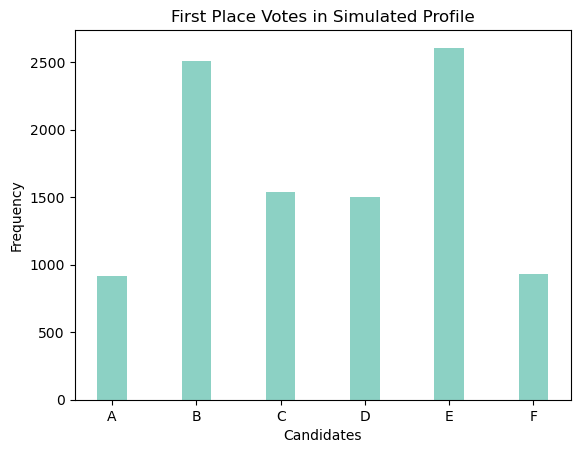

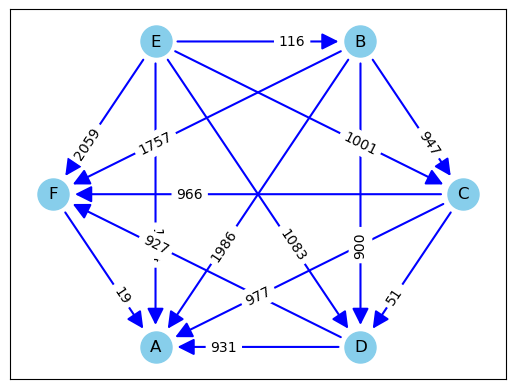

Current Round: 1
Candidate     Status  Round
        E    Elected      1
        B Eliminated      1
        C Eliminated      1
        D Eliminated      1
        F Eliminated      1
        A Eliminated      1
Current Round: 1
Candidate     Status  Round
        E    Elected      1
        B Eliminated      1
        C Eliminated      1
        D Eliminated      1
        F Eliminated      1
        A Eliminated      1
Current Round: 6
Candidate     Status  Round
        E    Elected      6
        B Eliminated      5
        C Eliminated      4
        D Eliminated      3
        F Eliminated      2
        A Eliminated      1


In [15]:
profile = simulateProfileTwo()
print(profile)

fig1 = plot_summary_stats(profile, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
plt.show()

pwc_graph = PairwiseComparisonGraph(profile)
pwc_graph.draw()
plt.show()

electionPlurality = Plurality(profile = profile,
                     seats = 1)
print(electionPlurality.run_election())

electionDominatingSets = DominatingSets(profile = profile)
print(electionDominatingSets.run_election())

electionIRV = IRV(profile = profile)
print(electionIRV.run_election())

PreferenceProfile too long, only showing 15 out of 145 rows.
  Ballots Weight
     (E,)    907
     (B,)    904
     (D,)    511
     (C,)    469
   (B, C)    370
   (B, A)    341
   (E, D)    336
   (E, F)    309
     (F,)    298
     (A,)    274
   (D, E)    262
(B, A, C)    258
(B, C, A)    252
(E, F, D)    250
   (C, B)    239


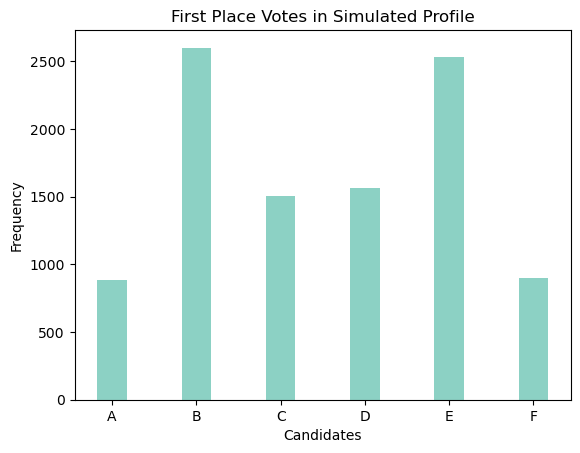

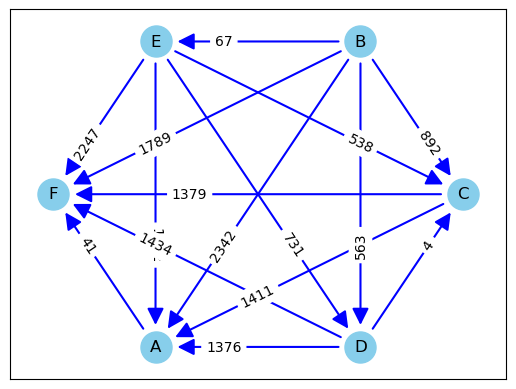

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        E Eliminated      1
        D Eliminated      1
        C Eliminated      1
        F Eliminated      1
        A Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        E Eliminated      1
        D Eliminated      1
        C Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 6
Candidate     Status  Round
        B    Elected      6
        E Eliminated      5
        D Eliminated      4
        C Eliminated      3
        F Eliminated      2
        A Eliminated      1


In [16]:
profile = simulateProfileThree()
print(profile)

fig1 = plot_summary_stats(profile, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
plt.show()

pwc_graph = PairwiseComparisonGraph(profile)
pwc_graph.draw()
plt.show()

electionPlurality = Plurality(profile = profile,
                     seats = 1)
print(electionPlurality.run_election())

electionDominatingSets = DominatingSets(profile = profile)
print(electionDominatingSets.run_election())

electionIRV = IRV(profile = profile)
print(electionIRV.run_election())

In [17]:
def simulateProfileLength(mu1 = 0.2, mu2 = 0.8, plot = False, l = [0.33, 0.33]):
    """
    Simulates preference profile based on distribution of voters (bimodal) on varying legnth distributions 
    We only do this for ranking three candidates
    """
    # Simulate voter bimodal distribution 
    numberBallots = 10000
    y = []
    temperature = 0.15
    for _ in range(10000):
        p = np.random.random()
        if p < 0.4: 
            y.append(np.random.normal(mu1, 0.05))
        elif p < 0.8:
            y.append(np.random.normal(mu2, 0.05))
        else:
            y.append(np.random.uniform(mu1, mu2))

    if plot == True:
        plot_colored_histogram(y)

    candidates = {'A': 0.0, 'B': 0.5, 'C': 1.0}

    distances = {}

    # Make dict of distances to candidates for each voter
    
    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points, temperature)
        distances[i] = dist_to_other_points

    # Sample from distribution of lengths 
    # Then pick ranking of candidate probabilistically based on distances

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        if lengths[i] < l[0]:
            dict_ballot[i] = simulateBallot(distances[i], 1)
        elif lengths[i] < l[1]:
            dict_ballot[i] = simulateBallot(distances[i], 2)
        else:
            dict_ballot[i] = simulateBallot(distances[i], 3)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candiddates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile

In [18]:
def lengthTrials():
    """
    Simulates elections based on different distributions of the length of cast vote records
    Assumes that we we only rank three candidates 
    """
    # Might be a good idea to sample from dirchelet distribution
    listOfLengths = [[0.1, 0],
                     [0.3, 0.3],
                     [0, 0.5],
                     [0.8, 0.9],
                     [1, 0], 
                     [0.5, 0.6]]
    for list in listOfLengths:
        profile = simulateProfileLength(plot = True, l = list)
        print(profile)
        fig1 = plot_summary_stats(profile, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
        plt.show()
        pwc_graph = PairwiseComparisonGraph(profile)
        pwc_graph.draw()
        plt.show()


        electionPlurality = Plurality(profile = profile,
                     seats = 1)
        print(electionPlurality.run_election())

        electionDominatingSets = DominatingSets(profile = profile)
        print(electionDominatingSets.run_election())

        electionIRV = IRV(profile = profile)
        print(electionIRV.run_election())

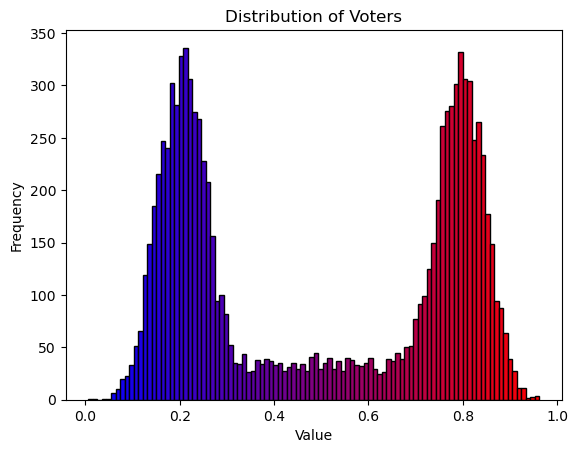

  Ballots Weight
(A, B, C)   2518
(C, B, A)   2427
(B, A, C)   1942
(B, C, A)   1880
     (B,)    410
     (C,)    305
     (A,)    285
(A, C, B)    118
(C, A, B)    115


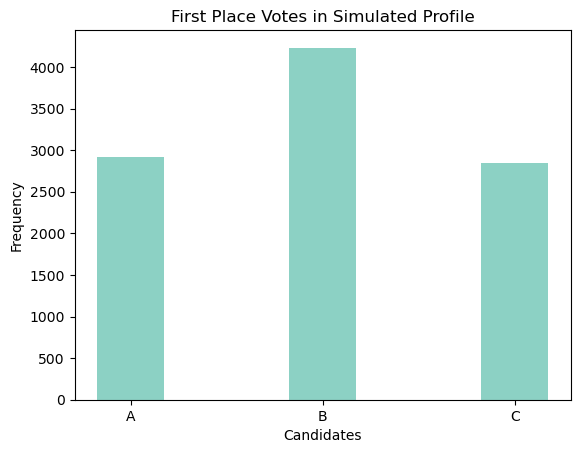

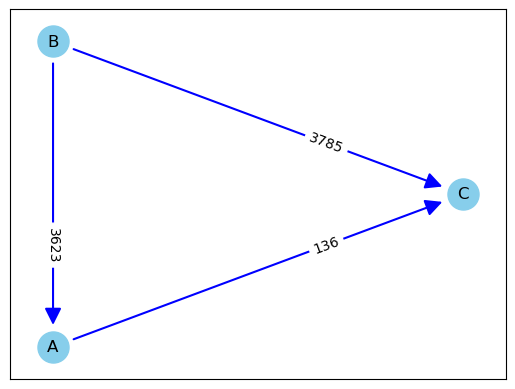

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        A Eliminated      1
        C Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        A Eliminated      1
        C Eliminated      1
Current Round: 2
Candidate     Status  Round
        B    Elected      2
        A  Remaining      2
        C Eliminated      1


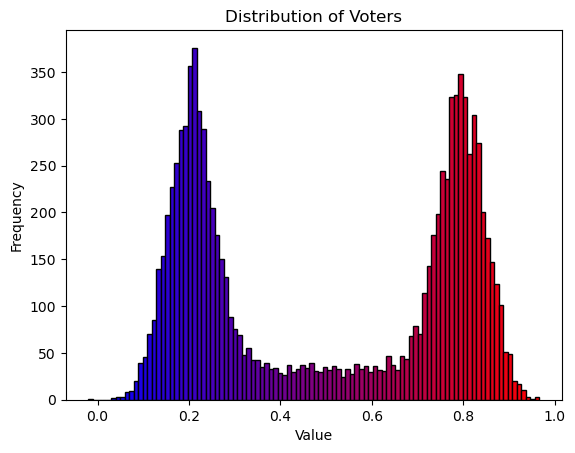

  Ballots Weight
(A, B, C)   1904
(C, B, A)   1894
(B, A, C)   1495
(B, C, A)   1434
     (B,)   1283
     (C,)    919
     (A,)    879
(A, C, B)    107
(C, A, B)     85


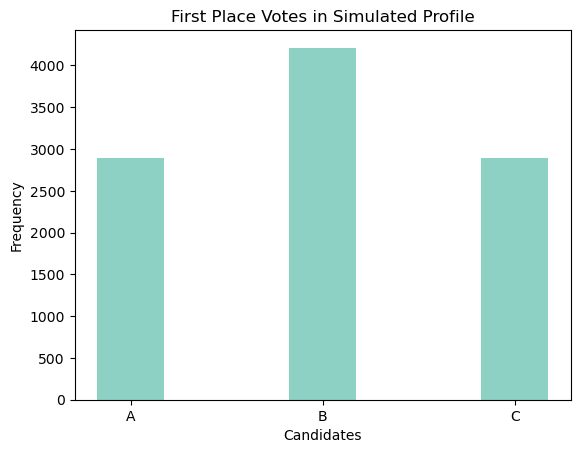

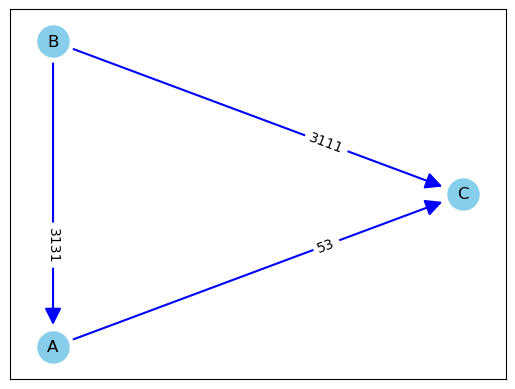

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        C Eliminated      1
        A Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        A Eliminated      1
        C Eliminated      1
Current Round: 2
Candidate     Status  Round
        B    Elected      2
        C  Remaining      2
        A Eliminated      1


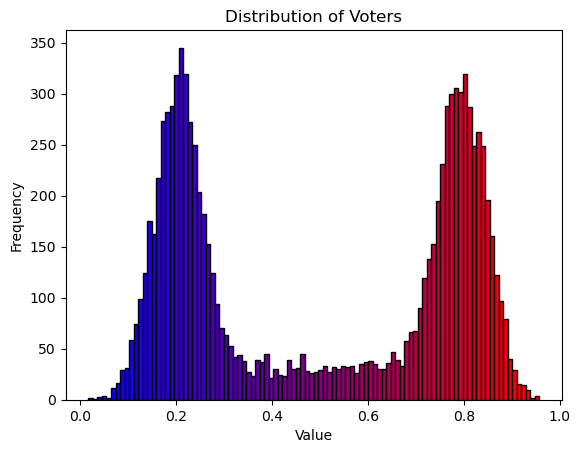

  Ballots Weight
(C, B, A)   1410
   (C, B)   1386
(A, B, C)   1370
   (A, B)   1356
   (B, C)   1074
(B, C, A)   1054
(B, A, C)   1049
   (B, A)   1026
(C, A, B)     82
(A, C, B)     71
   (A, C)     63
   (C, A)     59


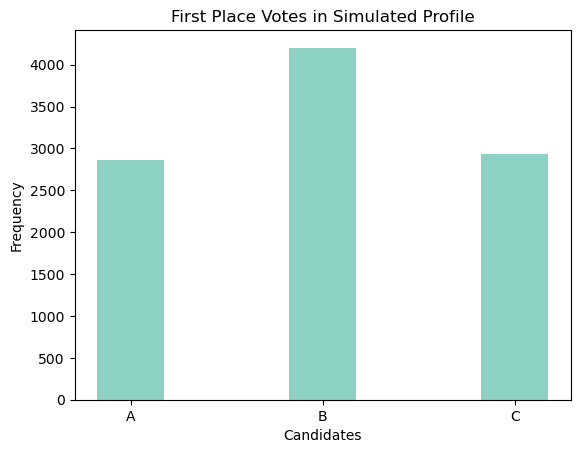

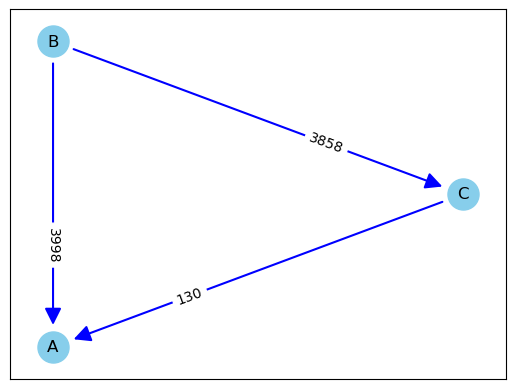

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        C Eliminated      1
        A Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        C Eliminated      1
        A Eliminated      1
Current Round: 2
Candidate     Status  Round
        B    Elected      2
        C  Remaining      2
        A Eliminated      1


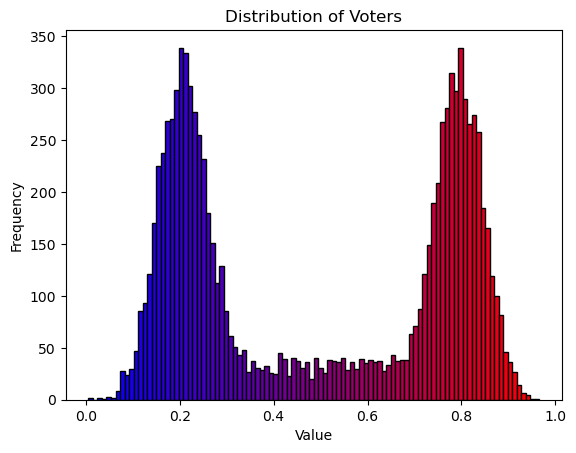

PreferenceProfile too long, only showing 15 out of 15 rows.
  Ballots Weight
     (B,)   3360
     (A,)   2309
     (C,)   2261
(A, B, C)    293
(C, B, A)    290
   (C, B)    286
   (A, B)    281
(B, C, A)    224
(B, A, C)    220
   (B, A)    215
   (B, C)    212
(A, C, B)     15
   (C, A)     14
(C, A, B)     11
   (A, C)      9


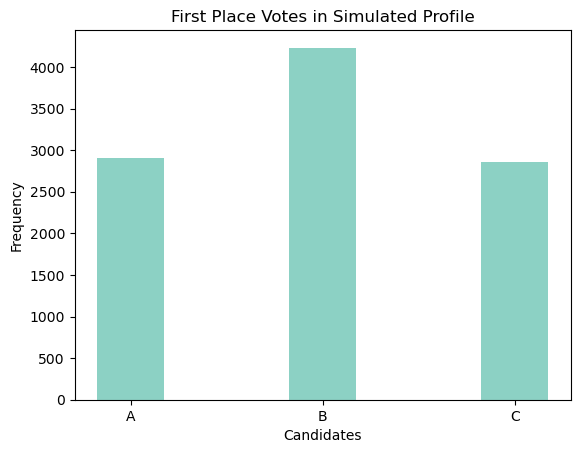

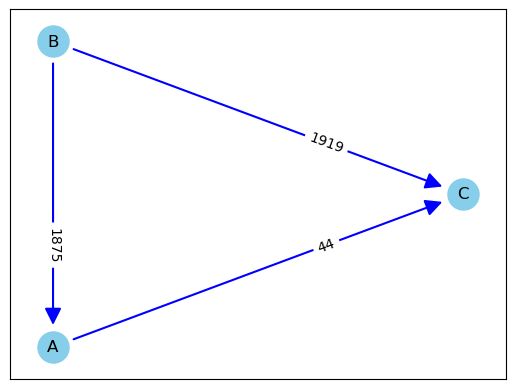

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        A Eliminated      1
        C Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        A Eliminated      1
        C Eliminated      1
Current Round: 3
Candidate     Status  Round
        B    Elected      3
        A Eliminated      2
        C Eliminated      1


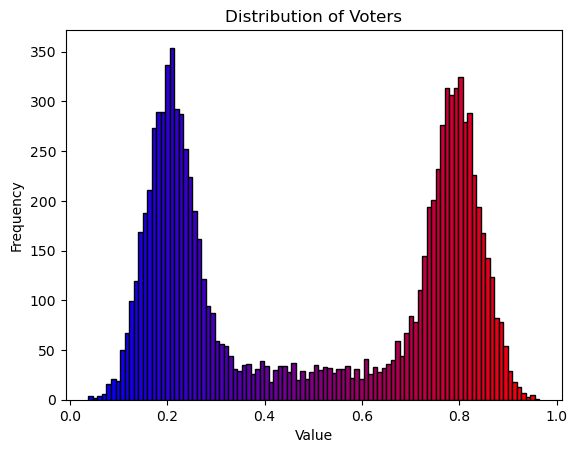

Ballots Weight
   (B,)   4222
   (A,)   2950
   (C,)   2828


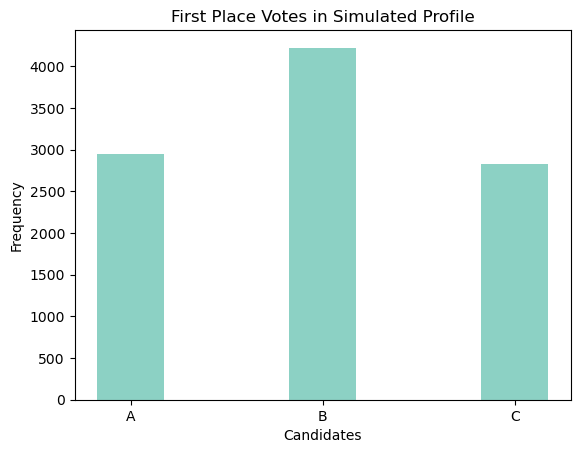

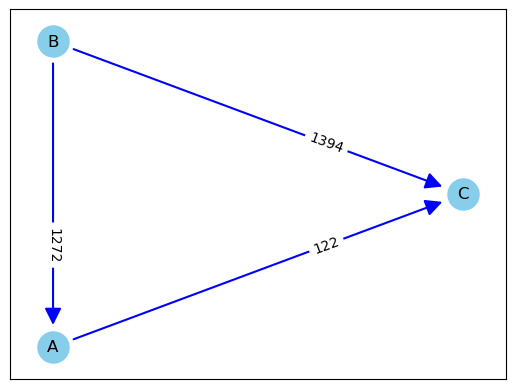

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        A Eliminated      1
        C Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        A Eliminated      1
        C Eliminated      1
Current Round: 3
Candidate     Status  Round
        B    Elected      3
        A Eliminated      2
        C Eliminated      1


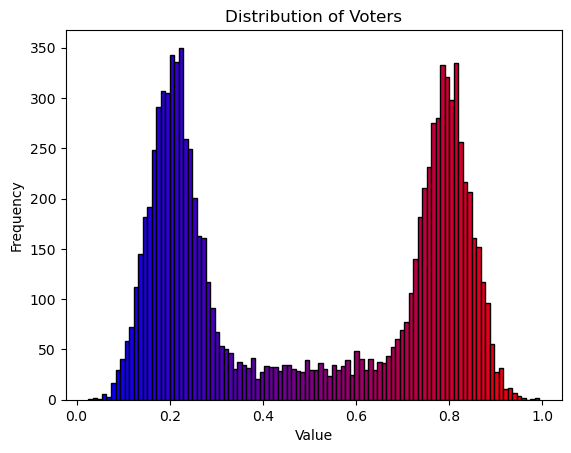

PreferenceProfile too long, only showing 15 out of 15 rows.
  Ballots Weight
     (B,)   2064
     (C,)   1500
     (A,)   1457
(C, B, A)   1103
(A, B, C)   1054
(B, A, C)    883
(B, C, A)    868
   (A, B)    291
   (C, B)    245
   (B, C)    215
   (B, A)    208
(A, C, B)     51
(C, A, B)     46
   (A, C)     10
   (C, A)      5


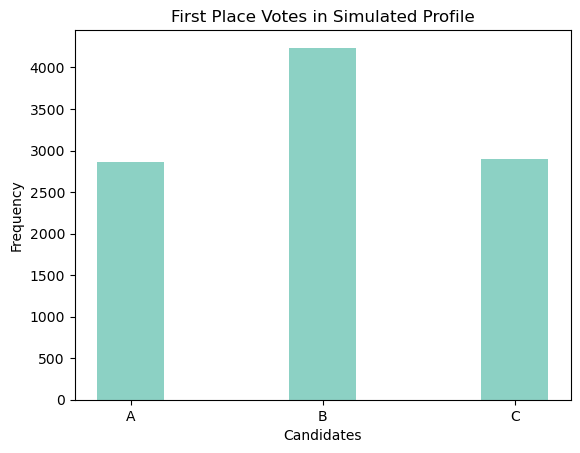

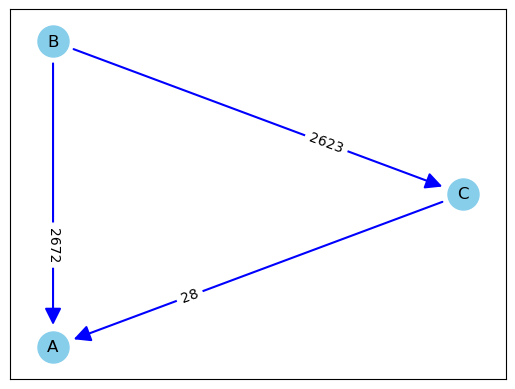

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        C Eliminated      1
        A Eliminated      1
Current Round: 1
Candidate     Status  Round
        B    Elected      1
        C Eliminated      1
        A Eliminated      1
Current Round: 2
Candidate     Status  Round
        B    Elected      2
        C  Remaining      2
        A Eliminated      1


In [77]:
lengthTrials()

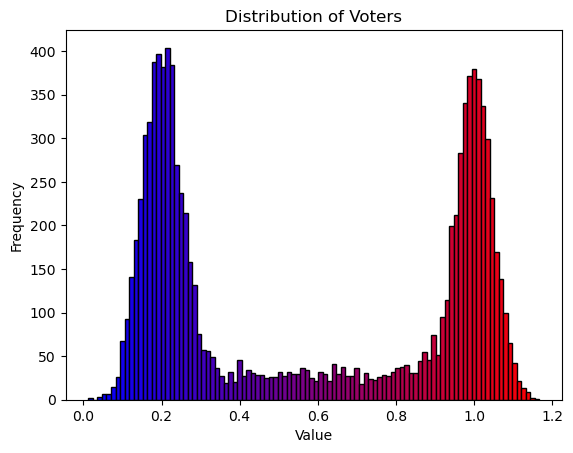

In [19]:
# Simulate bimodal distribution
numberBallots = 10000
y = []
for _ in range(10000):
    p = np.random.random()
    if p < 0.4: 
        y.append(np.random.normal(0.2, 0.05))
    elif p < 0.8:
        y.append(np.random.normal(1, 0.05))
    else:
        y.append(np.random.uniform(0.1, 0.9))

plot_colored_histogram(y)

In [20]:
def f(x):
    temp = 22
    for i in range(1,9):
        temp += -math.log(.01+ ((i-4.1)-(x+1)/.8)**2)
    return temp

In [21]:
import numpy as np
from scipy.integrate import quad

def pdf_unnormalized(x):
    return np.exp(f(x))

# Integrate to find the normalization constant
a, b = -4, 3  # Example range; adjust based on your specific use case
integral, _ = quad(pdf_unnormalized, a, b)

def pdf(x):
    return pdf_unnormalized(x) / integral


In [22]:
import random

def metropolis_hastings(pdf, num_samples, start, proposal_width):
    samples = [start]
    current = start

    for _ in range(num_samples):
        proposed = random.gauss(current, proposal_width)
        acceptance_ratio = min(1, pdf(proposed) / pdf(current))

        if random.random() < acceptance_ratio:
            current = proposed

        samples.append(current)

    return samples

# Parameters
num_samples = 10000
start = 0
proposal_width = 0.5

samples = metropolis_hastings(pdf, num_samples, start, proposal_width)


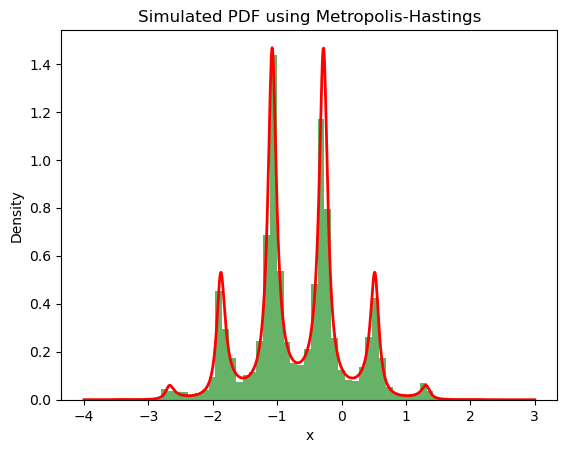

In [23]:
import matplotlib.pyplot as plt

plt.hist(samples, bins=50, density=True, alpha=0.6, color='g')
x = np.linspace(a, b, 1000)
plt.plot(x, [pdf(xi) for xi in x], linewidth=2, color='r')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Simulated PDF using Metropolis-Hastings')
plt.show()

In [24]:
def rescaled_f(x, old_min, old_max, new_min, new_max):
    return ((x - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min

# Define the old range of the function, e.g., [-10, 10]
old_min, old_max = -10, 10

def shifted_pdf(x):
    # Rescale x to the old range
    original_x = rescaled_f(x, 0, 1, old_min, old_max)
    return pdf(original_x)


In [25]:
import random

def metropolis_hastings(pdf, num_samples, start, proposal_width):
    samples = [start]
    current = start

    for _ in range(num_samples):
        proposed = random.gauss(current, proposal_width)
        acceptance_ratio = min(1, pdf(proposed) / pdf(current))

        if random.random() < acceptance_ratio:
            current = proposed

        samples.append(current)

    return samples

# Parameters
num_samples = 10000
start = 0.5  # Start in the middle of the new range [0, 1]
proposal_width = 0.1

samples = metropolis_hastings(shifted_pdf, num_samples, start, proposal_width)


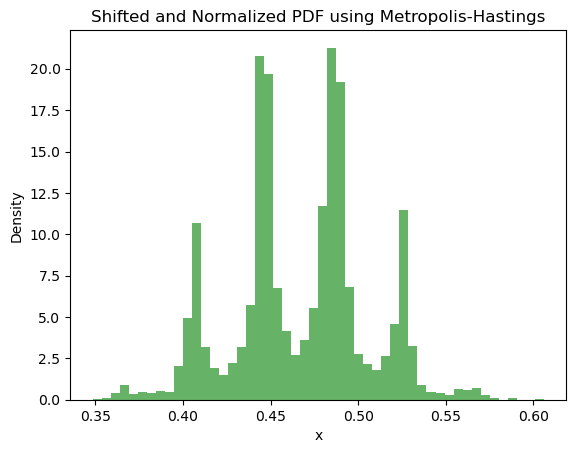

In [26]:
import matplotlib.pyplot as plt

plt.hist(samples, bins=50, density=True, alpha=0.6, color='g')
x = np.linspace(0, 1, 1000)
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Shifted and Normalized PDF using Metropolis-Hastings')
plt.show()


In [27]:
### Functions for generating ballot profiles ###

def simulateProfileBumpy(plot = False):
    """
    Simulates preference profile based on distribution of voters (bimodal)
    """
    # Simulate voter bimodal distribution 
    numberBallots = 10000
    y = []
    num_samples = 10000
    start = 0.5  # Start in the middle of the new range [0, 1]
    proposal_width = 0.5

    y = metropolis_hastings(shifted_pdf, num_samples, start, proposal_width)

    if plot == True:
        plot_colored_histogram(samples)

    candidates = {'A': 0.0, 'B': 0.2, 'C': 0.4, 'D': 0.6, 'E': 0.8, 'F': 1.0}

    distances = {}

    # Make dict of distances to candidates for each voter
    
    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points)
        distances[i] = dist_to_other_points

    # Sample from distribution of lengths 
    # Then pick ranking of candidate probabilistically based on distances

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        if lengths[i] < .25:
            dict_ballot[i] = simulateBallot(distances[i], 1)
        elif lengths[i] < .5:
            dict_ballot[i] = simulateBallot(distances[i], 2)
        elif lengths[i] < 0.75:
            dict_ballot[i] = simulateBallot(distances[i], 3)
        else:
            dict_ballot[i] = simulateBallot(distances[i], 4)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candiddates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile


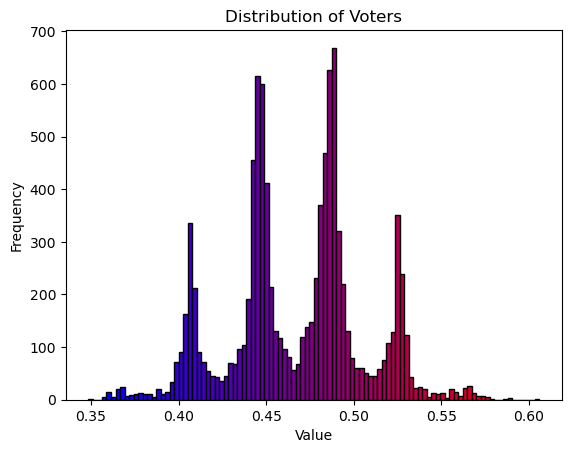

PreferenceProfile too long, only showing 15 out of 516 rows.
Ballots Weight
   (C,)    544
   (D,)    482
   (E,)    410
   (B,)    383
   (A,)    343
   (F,)    330
 (C, D)    138
 (C, E)    119
 (D, C)    116
 (B, C)    107
 (A, B)    104
 (D, E)    100
 (D, B)     98
 (C, B)     97
 (E, C)     91


In [28]:
profile = simulateProfileBumpy(plot = True)
print(profile)

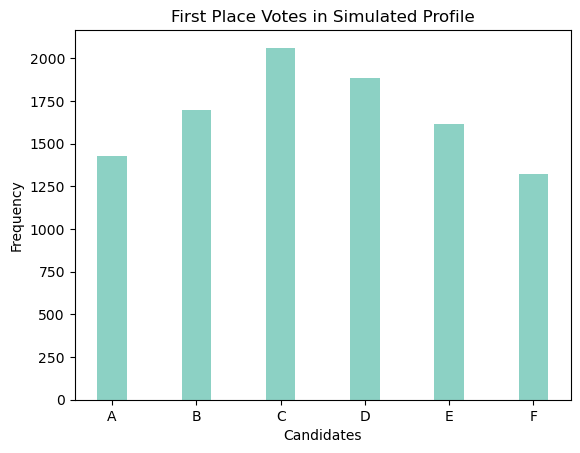

In [29]:
fig1 = plot_summary_stats(profile, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
plt.show()

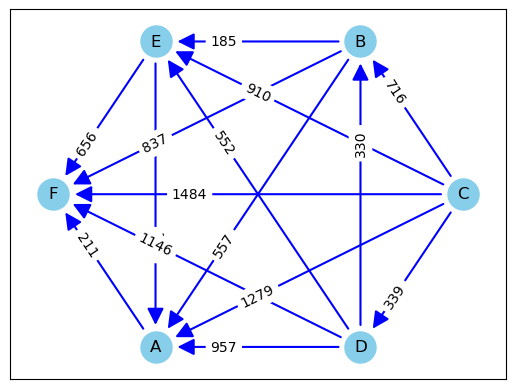

Current Round: 1
Candidate     Status  Round
        C    Elected      1
        D Eliminated      1
        B Eliminated      1
        E Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 1
Candidate     Status  Round
        C    Elected      1
        D Eliminated      1
        B Eliminated      1
        E Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 6
Candidate     Status  Round
        C    Elected      6
        D Eliminated      5
        B Eliminated      4
        E Eliminated      3
        A Eliminated      2
        F Eliminated      1


In [30]:
pwc_graph = PairwiseComparisonGraph(profile)
pwc_graph.draw()
plt.show()

electionPlurality = Plurality(profile = profile,
                     seats = 1)
print(electionPlurality.run_election())

electionDominatingSets = DominatingSets(profile = profile)
print(electionDominatingSets.run_election())

electionIRV = IRV(profile = profile)
print(electionIRV.run_election())

In [31]:
### Functions for generating ballot profiles ###

def simulateProfileTriModal(plot = False):
    """
    Simulates preference profile based on distribution of voters (bimodal)
    """
    numberBallots = 10000
    # Simulate voter bimodal distribution 
    y = []
    for _ in range(numberBallots):
        p = np.random.random()
        if p < 0.33: 
            y.append(np.random.normal(0.1, 0.05))
        elif p < 0.66:
            y.append(np.random.normal(0.5, 0.05))
        else:
             y.append(np.random.normal(0.9, 0.05))

    if plot == True:
        plot_colored_histogram(y)

    candidates = {'A': 0.0, 'B': 0.2, 'C': 0.4, 'D': 0.6, 'E': 0.8, 'F': 1.0}

    distances = {}

    # Make dict of distances to candidates for each voter
    
    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points)
        distances[i] = dist_to_other_points

    # Sample from distribution of lengths 
    # Then pick ranking of candidate probabilistically based on distances

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        if lengths[i] < .25:
            dict_ballot[i] = simulateBallot(distances[i], 1)
        elif lengths[i] < .5:
            dict_ballot[i] = simulateBallot(distances[i], 2)
        elif lengths[i] < 0.75:
            dict_ballot[i] = simulateBallot(distances[i], 3)
        else:
            dict_ballot[i] = simulateBallot(distances[i], 4)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candiddates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile


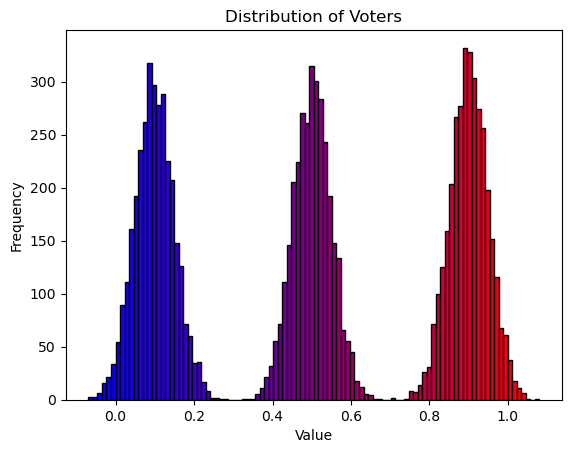

PreferenceProfile too long, only showing 15 out of 515 rows.
Ballots Weight
   (C,)    447
   (E,)    446
   (D,)    438
   (B,)    436
   (F,)    379
   (A,)    368
 (C, B)    104
 (E, C)     98
 (B, C)     98
 (E, D)     94
 (F, D)     93
 (C, A)     93
 (D, B)     91
 (B, D)     89
 (D, F)     89


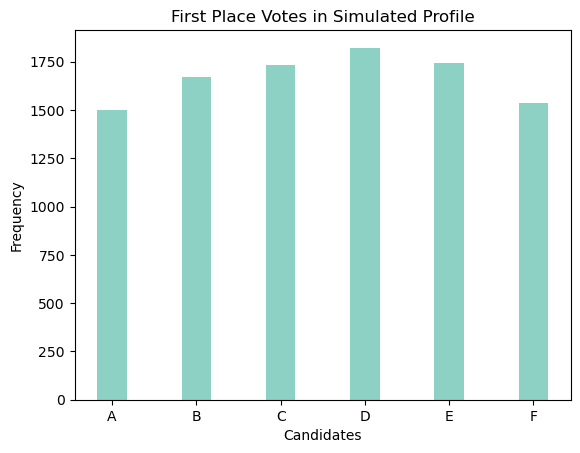

In [32]:
profile = simulateProfileTriModal(plot = True)
print(profile)

fig1 = plot_summary_stats(profile, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
plt.show()

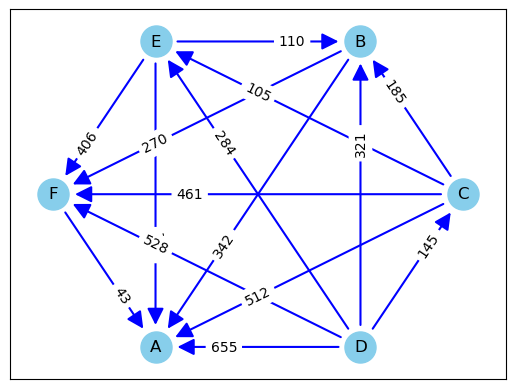

Current Round: 1
Candidate     Status  Round
        D    Elected      1
        E Eliminated      1
        C Eliminated      1
        B Eliminated      1
        F Eliminated      1
        A Eliminated      1
Current Round: 1
Candidate     Status  Round
        D    Elected      1
        C Eliminated      1
        E Eliminated      1
        B Eliminated      1
        F Eliminated      1
        A Eliminated      1
Current Round: 6
Candidate     Status  Round
        D    Elected      6
        C Eliminated      5
        E Eliminated      4
        B Eliminated      3
        F Eliminated      2
        A Eliminated      1


In [33]:
pwc_graph = PairwiseComparisonGraph(profile)
pwc_graph.draw()
plt.show()

electionPlurality = Plurality(profile = profile,
                     seats = 1)
print(electionPlurality.run_election())

electionDominatingSets = DominatingSets(profile = profile)
print(electionDominatingSets.run_election())

electionIRV = IRV(profile = profile)
print(electionIRV.run_election())

In [34]:
### Functions for generating ballot profiles ###

def simulateProfileSomeOverlap(plot = False):
    """
    Simulates preference profile based on distribution of voters (bimodal)
    """
    numberBallots = 10000
    # Simulate voter bimodal distribution 
    y = []
    for _ in range(numberBallots):
        p = np.random.random()
        if p < .6: 
            y.append(np.random.normal(0.3, 0.05))
        else:
             y.append(np.random.normal(0.5, 0.05))

    if plot == True:
        plot_colored_histogram(y)

    candidates = {'A': 0.0, 'B': 0.2, 'C': 0.4, 'D': 0.6, 'E': 0.8, 'F': 1.0}

    distances = {}

    # Make dict of distances to candidates for each voter
    
    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points)
        distances[i] = dist_to_other_points

    # Sample from distribution of lengths 
    # Then pick ranking of candidate probabilistically based on distances

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        if lengths[i] < .25:
            dict_ballot[i] = simulateBallot(distances[i], 1)
        elif lengths[i] < .5:
            dict_ballot[i] = simulateBallot(distances[i], 2)
        elif lengths[i] < 0.75:
            dict_ballot[i] = simulateBallot(distances[i], 3)
        else:
            dict_ballot[i] = simulateBallot(distances[i], 4)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candiddates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile


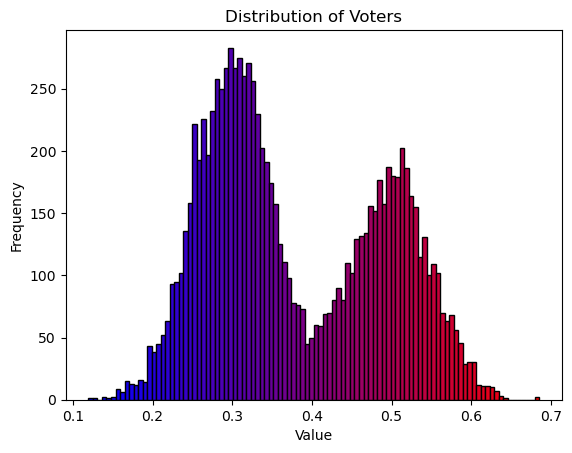

PreferenceProfile too long, only showing 15 out of 516 rows.
Ballots Weight
   (C,)    528
   (B,)    477
   (D,)    437
   (A,)    393
   (E,)    381
   (F,)    331
 (D, C)    122
 (C, B)    122
 (B, C)    117
 (C, E)    110
 (B, D)    109
 (C, A)    105
 (E, C)    104
 (D, B)    100
 (C, D)     99


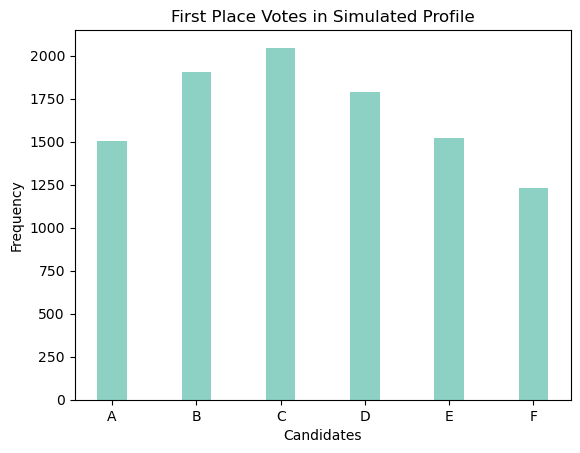

In [35]:
profile = simulateProfileSomeOverlap(plot = True)
print(profile)

fig1 = plot_summary_stats(profile, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
plt.show()

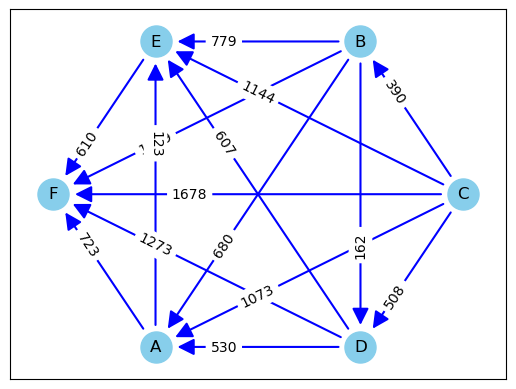

Current Round: 1
Candidate     Status  Round
        C    Elected      1
        B Eliminated      1
        D Eliminated      1
        E Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 1
Candidate     Status  Round
        C    Elected      1
        B Eliminated      1
        D Eliminated      1
        A Eliminated      1
        E Eliminated      1
        F Eliminated      1
Current Round: 6
Candidate     Status  Round
        C    Elected      6
        B Eliminated      5
        D Eliminated      4
        E Eliminated      3
        A Eliminated      2
        F Eliminated      1


In [36]:
pwc_graph = PairwiseComparisonGraph(profile)
pwc_graph.draw()
plt.show()

electionPlurality = Plurality(profile = profile,
                     seats = 1)
print(electionPlurality.run_election())

electionDominatingSets = DominatingSets(profile = profile)
print(electionDominatingSets.run_election())

electionIRV = IRV(profile = profile)
print(electionIRV.run_election())

In [4]:
### Functions for generating ballot profiles ###

def simulateProfileBigOverlap(plot = False):
    """
    Simulates preference profile based on distribution of voters (bimodal)
    """
    numberBallots = 10000
    # Simulate voter bimodal distribution 
    y = []
    for _ in range(numberBallots):
        p = np.random.random()
        if p < .6: 
            y.append(np.random.normal(0.4, 0.05))
        else:
             y.append(np.random.normal(0.5, 0.05))

    if plot == True:
        plot_colored_histogram(y)

    candidates = {'A': 0.0, 'B': 0.2, 'C': 0.4, 'D': 0.6, 'E': 0.8, 'F': 1.0}

    distances = {}

    # Make dict of distances to candidates for each voter
    
    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points)
        distances[i] = dist_to_other_points

    # Sample from distribution of lengths 
    # Then pick ranking of candidate probabilistically based on distances

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        if lengths[i] < .25:
            dict_ballot[i] = simulateBallot(distances[i], 1)
        elif lengths[i] < .5:
            dict_ballot[i] = simulateBallot(distances[i], 2)
        elif lengths[i] < 0.75:
            dict_ballot[i] = simulateBallot(distances[i], 3)
        else:
            dict_ballot[i] = simulateBallot(distances[i], 4)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candiddates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile


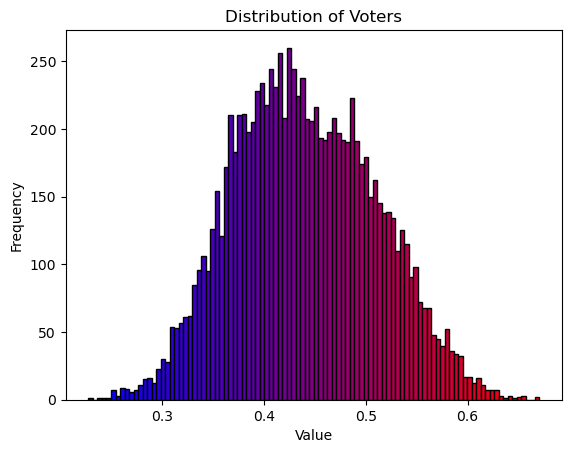

PreferenceProfile too long, only showing 15 out of 515 rows.
Ballots Weight
   (C,)    528
   (D,)    459
   (B,)    427
   (E,)    385
   (A,)    375
   (F,)    326
 (C, D)    125
 (C, B)    116
 (D, C)    113
 (C, A)    108
 (B, C)    107
 (A, C)    106
 (D, B)    104
 (C, E)    103
 (B, D)    101


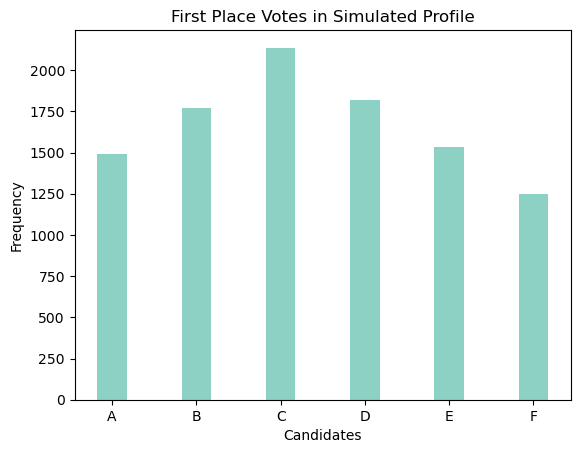

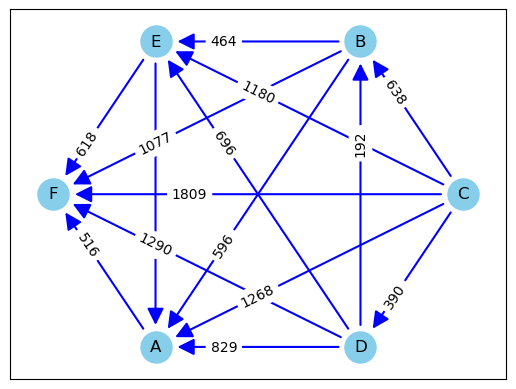

Current Round: 1
Candidate     Status  Round
        C    Elected      1
        D Eliminated      1
        B Eliminated      1
        E Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 1
Candidate     Status  Round
        C    Elected      1
        D Eliminated      1
        B Eliminated      1
        E Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 6
Candidate     Status  Round
        C    Elected      6
        D Eliminated      5
        B Eliminated      4
        E Eliminated      3
        A Eliminated      2
        F Eliminated      1


In [5]:
profile = simulateProfileBigOverlap(plot = True)
print(profile)

fig1 = plot_summary_stats(profile, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
plt.show()

pwc_graph = PairwiseComparisonGraph(profile)
pwc_graph.draw()
plt.show()

electionPlurality = Plurality(profile = profile,
                     seats = 1)
print(electionPlurality.run_election())

electionDominatingSets = DominatingSets(profile = profile)
print(electionDominatingSets.run_election())

electionIRV = IRV(profile = profile)
print(electionIRV.run_election())

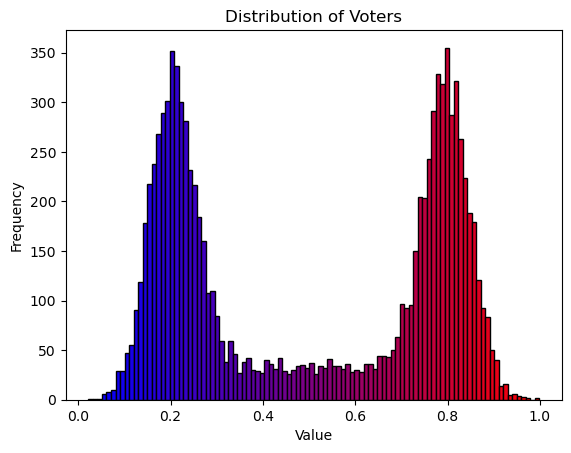

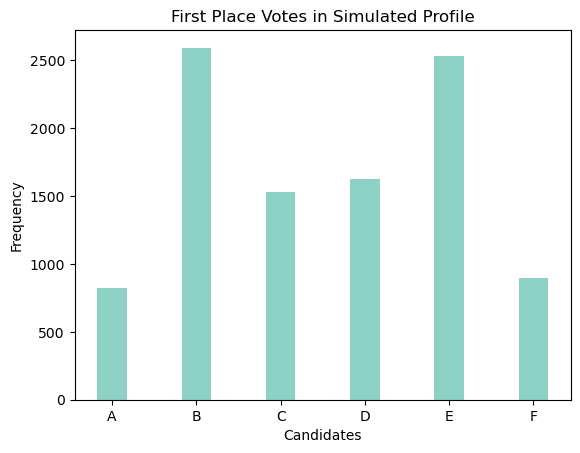

PreferenceProfile too long, only showing 15 out of 358 rows.
  Ballots Weight
     (B,)    681
     (E,)    599
     (D,)    414
     (C,)    397
   (E, D)    297
   (B, C)    292
   (E, F)    266
   (B, A)    263
     (F,)    229
     (A,)    201
(B, A, C)    198
   (D, E)    185
(E, F, D)    180
   (C, B)    173
(B, C, A)    159


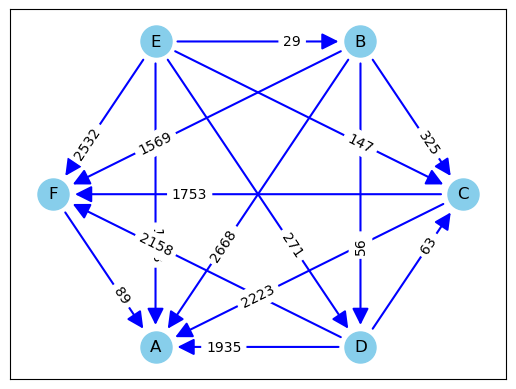

Current Round: 1
Candidate     Status  Round
        B    Elected      1
        E Eliminated      1
        D Eliminated      1
        C Eliminated      1
        F Eliminated      1
        A Eliminated      1
Current Round: 1
Candidate     Status  Round
        E    Elected      1
        B Eliminated      1
        D Eliminated      1
        C Eliminated      1
        F Eliminated      1
        A Eliminated      1
Current Round: 6
Candidate     Status  Round
        E    Elected      6
        B Eliminated      5
        D Eliminated      4
        C Eliminated      3
        F Eliminated      2
        A Eliminated      1


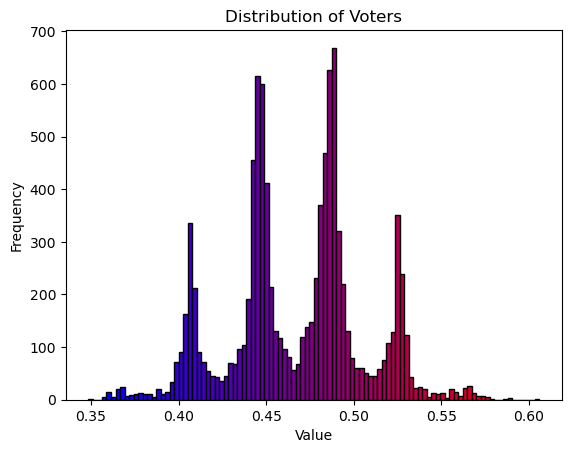

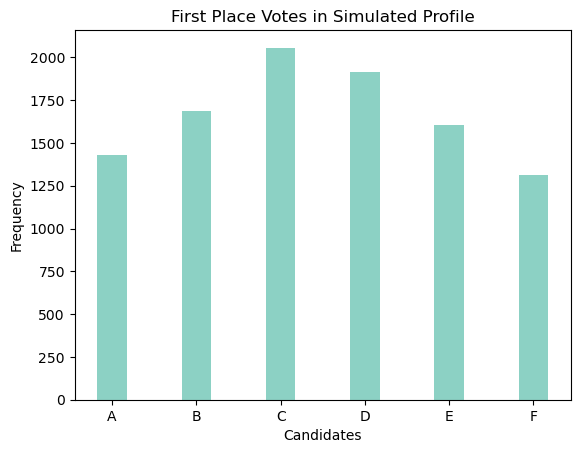

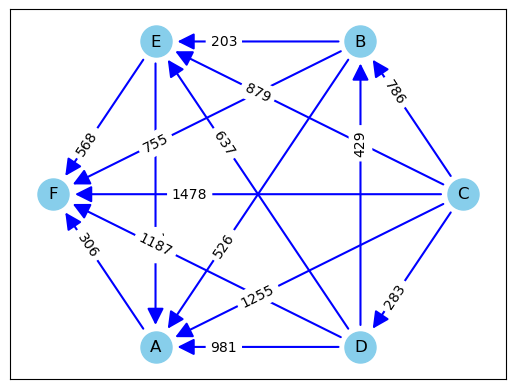

Current Round: 1
Candidate     Status  Round
        C    Elected      1
        D Eliminated      1
        B Eliminated      1
        E Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 1
Candidate     Status  Round
        C    Elected      1
        D Eliminated      1
        B Eliminated      1
        E Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 6
Candidate     Status  Round
        C    Elected      6
        D Eliminated      5
        B Eliminated      4
        E Eliminated      3
        A Eliminated      2
        F Eliminated      1


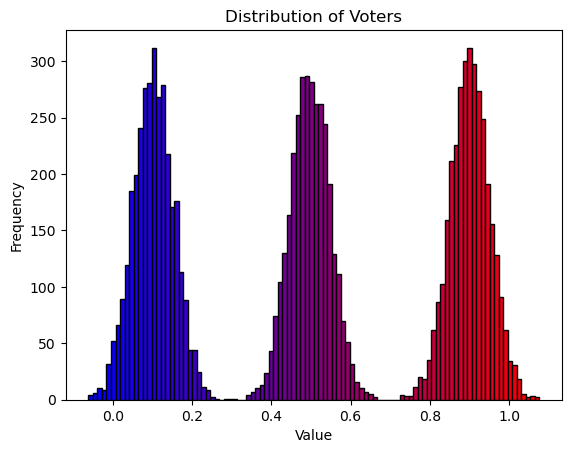

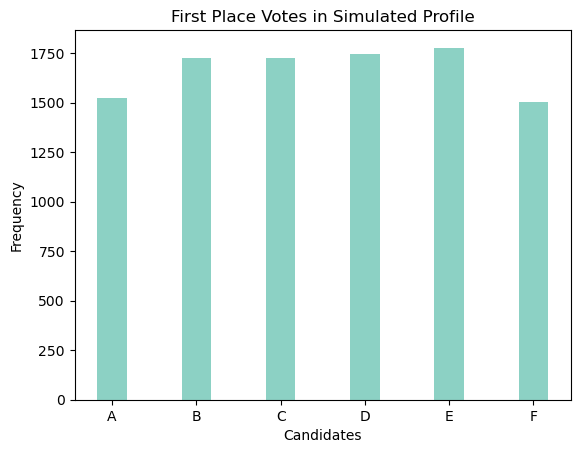

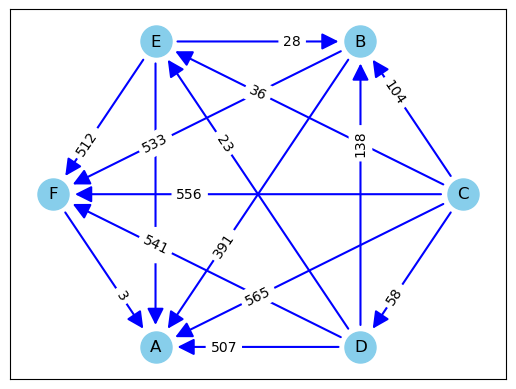

Current Round: 1
Candidate     Status  Round
        E    Elected      1
        D Eliminated      1
        C Eliminated      1
        B Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 1
Candidate     Status  Round
        C    Elected      1
        D Eliminated      1
        E Eliminated      1
        B Eliminated      1
        F Eliminated      1
        A Eliminated      1
Current Round: 6
Candidate     Status  Round
        C    Elected      6
        E Eliminated      5
        D Eliminated      4
        B Eliminated      3
        A Eliminated      2
        F Eliminated      1


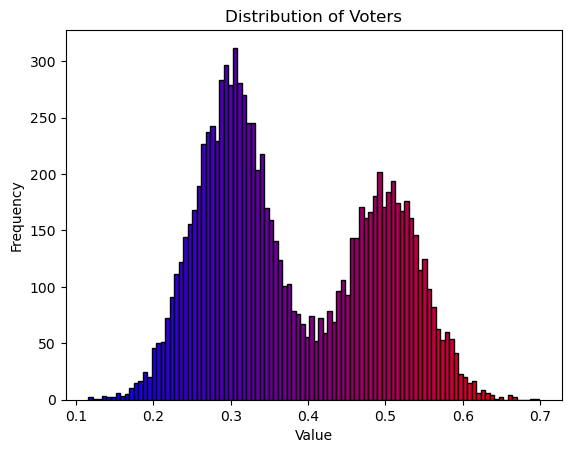

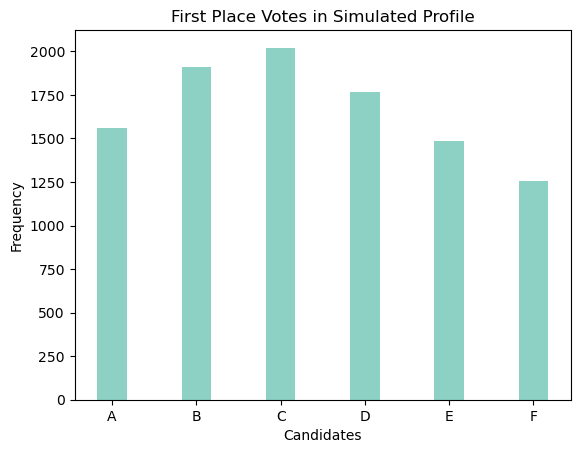

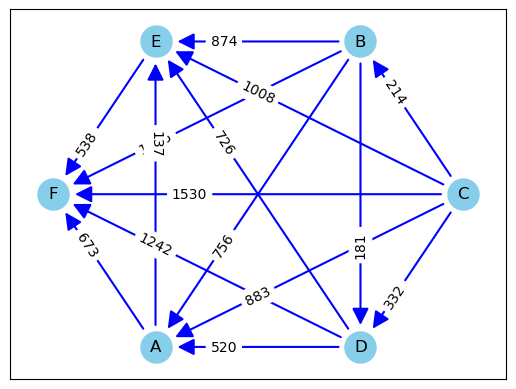

Current Round: 1
Candidate     Status  Round
        C    Elected      1
        B Eliminated      1
        D Eliminated      1
        A Eliminated      1
        E Eliminated      1
        F Eliminated      1
Current Round: 1
Candidate     Status  Round
        C    Elected      1
        B Eliminated      1
        D Eliminated      1
        A Eliminated      1
        E Eliminated      1
        F Eliminated      1
Current Round: 6
Candidate     Status  Round
        C    Elected      6
        B Eliminated      5
        D Eliminated      4
        A Eliminated      3
        E Eliminated      2
        F Eliminated      1


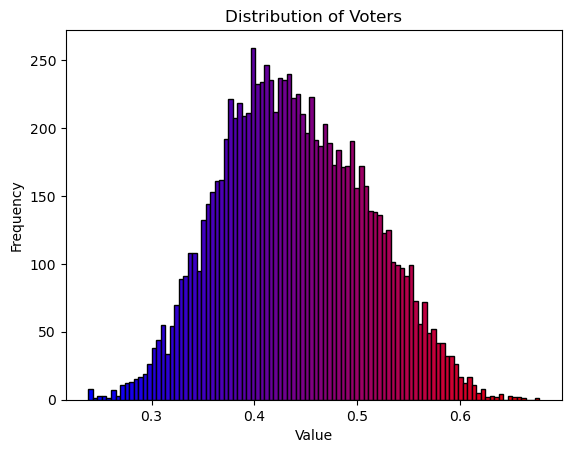

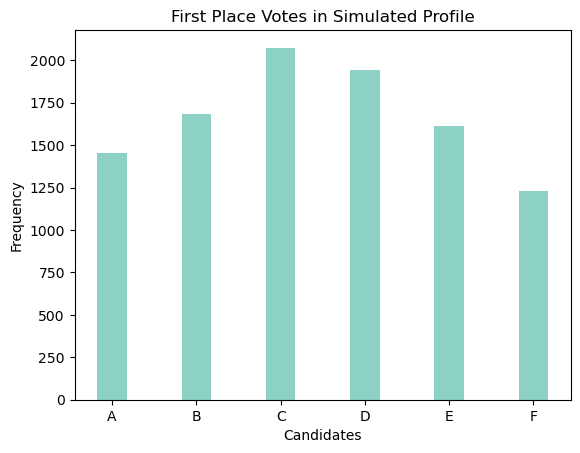

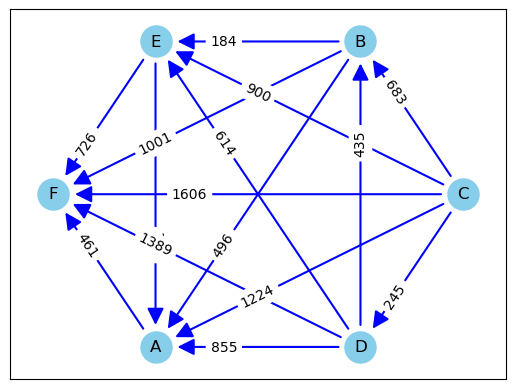

Current Round: 1
Candidate     Status  Round
        C    Elected      1
        D Eliminated      1
        B Eliminated      1
        E Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 1
Candidate     Status  Round
        C    Elected      1
        D Eliminated      1
        B Eliminated      1
        E Eliminated      1
        A Eliminated      1
        F Eliminated      1
Current Round: 6
Candidate     Status  Round
        C    Elected      6
        D Eliminated      5
        B Eliminated      4
        E Eliminated      3
        A Eliminated      2
        F Eliminated      1


In [42]:
profile1 = simulateProfile(plot = True)
fig1 = plot_summary_stats(profile1, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
plt.show()
print(profile1)

pwc_graph = PairwiseComparisonGraph(profile1)
pwc_graph.draw()
plt.show()

electionPlurality = Plurality(profile = profile1,
                     seats = 1)
print(electionPlurality.run_election())

electionDominatingSets = DominatingSets(profile = profile1)
print(electionDominatingSets.run_election())

electionIRV = IRV(profile = profile1)
print(electionIRV.run_election())

profile2 = simulateProfileBumpy(plot = True)
fig1 = plot_summary_stats(profile2, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
plt.show()

pwc_graph = PairwiseComparisonGraph(profile2)
pwc_graph.draw()
plt.show()

electionPlurality = Plurality(profile = profile2,
                     seats = 1)
print(electionPlurality.run_election())

electionDominatingSets = DominatingSets(profile = profile2)
print(electionDominatingSets.run_election())

electionIRV = IRV(profile = profile2)
print(electionIRV.run_election())


profile3 = simulateProfileTriModal(plot = True)
fig1 = plot_summary_stats(profile3, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
plt.show()
pwc_graph = PairwiseComparisonGraph(profile3)
pwc_graph.draw()
plt.show()

electionPlurality = Plurality(profile = profile3,
                     seats = 1)
print(electionPlurality.run_election())

electionDominatingSets = DominatingSets(profile = profile3)
print(electionDominatingSets.run_election())

electionIRV = IRV(profile = profile3)
print(electionIRV.run_election())

profile4 = simulateProfileSomeOverlap(plot = True)
fig1 = plot_summary_stats(profile4, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
plt.show()
pwc_graph = PairwiseComparisonGraph(profile4)
pwc_graph.draw()
plt.show()

electionPlurality = Plurality(profile = profile4,
                     seats = 1)
print(electionPlurality.run_election())

electionDominatingSets = DominatingSets(profile = profile4)
print(electionDominatingSets.run_election())

electionIRV = IRV(profile = profile4)
print(electionIRV.run_election())

profile5 = simulateProfileBigOverlap(plot = True)
fig1 = plot_summary_stats(profile5, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
plt.show()

pwc_graph = PairwiseComparisonGraph(profile5)
pwc_graph.draw()
plt.show()

electionPlurality = Plurality(profile = profile5,
                     seats = 1)
print(electionPlurality.run_election())

electionDominatingSets = DominatingSets(profile = profile5)
print(electionDominatingSets.run_election())

electionIRV = IRV(profile = profile5)
print(electionIRV.run_election())

#for i in range(1,6):
#    fig1 = plot_summary_stats(f"profile{i}", "first place votes", multi_color = False,
#                          title = "First Place Votes in Simulated Profile")
#    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from votekit.plots import plot_MDS, compute_MDS
from votekit.metrics import lp_dist
from votekit import PreferenceInterval

In [63]:
coord_dict = compute_MDS(data =
                         {'pl1': [pl1.generate_profile(number_of_ballots)
                                         for i in range(10)],
                        'pl2': [pl2.generate_profile(number_of_ballots)
                                for i in range(10)],
                        'bt1': [bt1.generate_profile(number_of_ballots)
                                for i in range(10)],
                        'bt2': [bt2.generate_profile(number_of_ballots)
                                for i in range(10)],
                          },
            distance = earth_mover_dist)

NameError: name 'compute_MDS' is not defined

In [ ]:
def simulateProfileThree(mu1 = 0.2, mu2 = 0.8, plot = False):
    """
    Simulates preference profile based on distribution of voters on different lengths
    """
    # Simulate voter bimodal distribution 
    numberBallots = 100000
    y = []
    temperature = 0.15
    for _ in range(10000):
        p = np.random.random()
        if p < 0.4: 
            y.append(np.random.normal(mu1, 0.05))
        elif p < 0.8:
            y.append(np.random.normal(mu2, 0.05))
        else:
            y.append(np.random.uniform(mu1, mu2))

    if plot == True:
        plot_colored_histogram(y)

    candidates = {'A': 0.0, 'B': 0.2, 'C': 0.4, 'D': 0.6, 'E': 0.8, 'F': 1.0}

    distances = {}

    # Make dict of distances to candidates for each voter
    
    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points, temperature)
        distances[i] = dist_to_other_points

    # Sample from distribution of lengths 
    # Then pick ranking of candidate probabilistically based on distances

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        if lengths[i] < .33:
            dict_ballot[i] = simulateBallot(distances[i], 1)
        elif lengths[i] < .66:
            dict_ballot[i] = simulateBallot(distances[i], 2)
        else:
            dict_ballot[i] = simulateBallot(distances[i], 3)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candiddates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile

array([4.29519577e-01, 6.61488852e-01, 4.08858875e-01, 1.12499118e-01,
       2.56454738e-01, 8.37658909e-01, 5.90867166e-01, 2.96220022e-01,
       9.96480340e-01, 4.04230381e-01, 5.95501460e-01, 8.99921826e-01,
       3.40985812e-01, 7.45872965e-01, 3.08760470e-01, 7.68825982e-01,
       3.93511483e-01, 5.09636493e-01, 4.74592223e-01, 4.91445804e-02,
       5.89232592e-01, 4.47916329e-01, 6.77231815e-01, 9.41220359e-01,
       5.35938507e-01, 5.39501124e-01, 2.10908078e-01, 1.79760632e-01,
       7.11409849e-01, 9.50311977e-01, 5.21665528e-02, 4.23658777e-01,
       4.74731955e-01, 4.75329126e-01, 5.16693684e-01, 5.53409673e-02,
       8.55152881e-01, 8.34638813e-01, 8.62810843e-01, 4.05107557e-01,
       1.37527860e-01, 2.95217540e-01, 1.88573732e-01, 8.62264586e-01,
       3.64821503e-02, 8.05349682e-01, 2.04149220e-01, 3.92376834e-01,
       8.64708187e-01, 6.70272830e-01, 5.58999430e-01, 8.48298185e-01,
       6.26618338e-01, 8.72420885e-01, 7.36903044e-02, 4.21745160e-01,
      

PreferenceProfile too long, only showing 15 out of 5357 rows.
        Ballots Weight
(J, I, K, H, G)     35
(J, K, I, H, G)     35
(B, A, C, D, E)     34
(A, B, C, D, E)     24
(J, K, I, G, H)     24
(I, J, K, H, G)     24
(K, J, I, H, G)     23
(C, B, A, D, E)     23
(K, J, I, G, H)     22
(B, C, A, D, E)     22
(A, C, D, B, E)     20
(B, C, A, E, D)     20
(K, I, J, H, G)     20
(B, A, D, C, E)     19
(A, C, B, D, E)     19


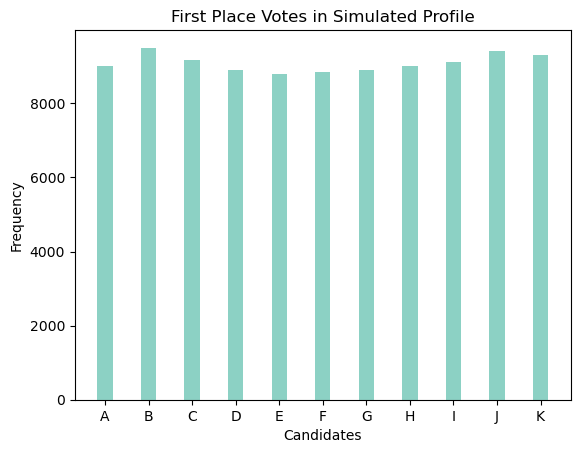

In [175]:
profile = simulateBallotsUniformAdjusted()
electionIRV = IRV(profile = profile)
state = electionIRV.run_election()
state.winners()

fig1 = plot_summary_stats(profile, "first place votes", multi_color = False,
                          title = "First Place Votes in Simulated Profile")
plt.show()

In [146]:
electionIRV = plurality(profile = profile)

NameError: name 'plurality' is not defined

In [151]:
profile = simulateBallotsUniform()

{0: {'A': 0.0015505732478797616, 'B': 0.0030201042980441233, 'C': 0.005882359948836076, 'D': 0.011457272714084655, 'E': 0.022315720082869597, 'F': 0.04346508765605257, 'G': 0.08465843082511898, 'H': 0.16489210758035672, 'I': 0.32116597103551076, 'J': 0.2257093357247074, 'K': 0.11588303688653938}}


In [160]:
epoch = 100
candidate_win_distribution = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'J': 0, 'K': 0}
for _ in range(epoch):
    if _ % 10 == 0:
        print(f"Finished run {_}")
    profile = simulateBallotsUniformA()
    electionIRV = IRV(profile = profile)
    state = electionIRV.run_election()
    candidate_win_distribution[next(iter(state.winners()[0]))] += 1

Finished run 0
Finished run 10
Finished run 20
Finished run 30
Finished run 40
Finished run 50
Finished run 60
Finished run 70
Finished run 80
Finished run 90


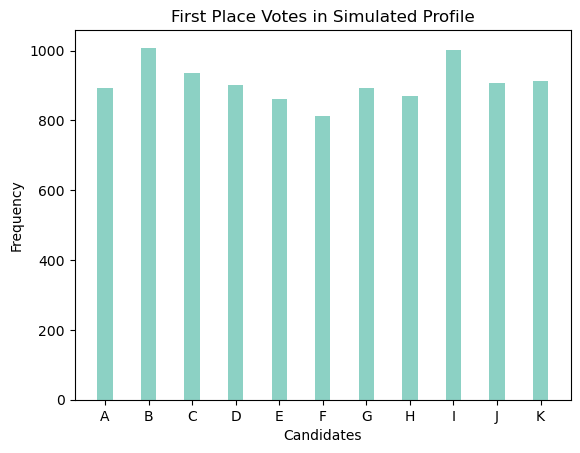

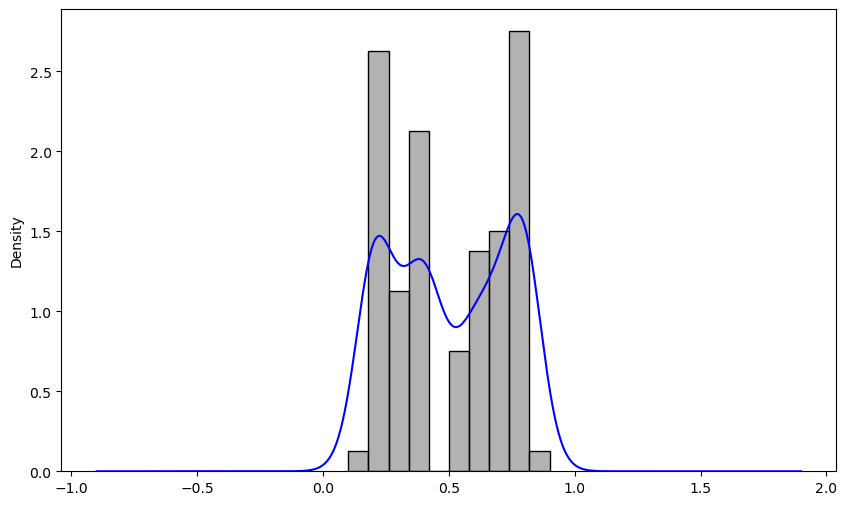

In [161]:
# Example dictionary with continuous values assigned to categorical variables
data = {'A': 0.0, 'B': 0.1, 'C': 0.2, 'D': 0.3, 'E': 0.4, 'F': 0.5, 'G': 0.6, 'H': 0.7, 'I': 0.8, 'J': 0.9, 'K': 1.0}

# Example frequencies for each category (can be changed to actual frequencies)
frequencies = candidate_win_distribution

# Expand the data according to the frequencies
expanded_data = []
for category, freq in frequencies.items():
    expanded_data.extend([data[category]] * freq)

kde = gaussian_kde(expanded_data, bw_method=0.3)

# Create an array of values for the x-axis
x = np.linspace(min(expanded_data) - 1, max(expanded_data) + 1, 1000)
kde_values = kde(x)

# Plot the histogram and KDE
plt.figure(figsize=(10, 6))
sns.histplot(expanded_data, kde=False, stat="density", alpha=0.6, color="gray", bins=10)
plt.plot(x, kde_values, color='blue')

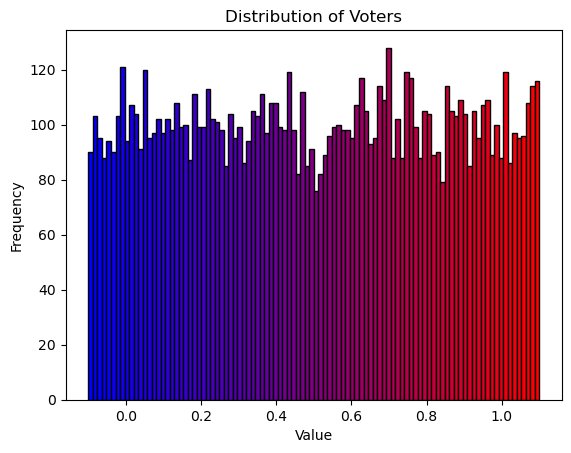

{0: {'A': 0.48690101818768106, 'B': 0.2499833180119549, 'C': 0.12834571493990612, 'D': 0.06589488720462493, 'E': 0.033831563147576134, 'F': 0.01736970368359775, 'G': 0.00891790322368256, 'H': 0.004578604180914564, 'I': 0.002350733767755735, 'J': 0.0012069069586537807, 'K': 0.000619646693652412}, 1: {'A': 0.0008886143921409742, 'B': 0.001730784500944083, 'C': 0.0033711078902186205, 'D': 0.006566021593846813, 'E': 0.012788863772635526, 'F': 0.024909305316373136, 'G': 0.04851670190372415, 'H': 0.09449763185758572, 'I': 0.18405625436807266, 'J': 0.35849263210171345, 'K': 0.264182082302745}, 2: {'A': 0.031450865083587125, 'B': 0.06125792054392055, 'C': 0.11931413712761664, 'D': 0.23239220646252448, 'E': 0.272904360269552, 'F': 0.140113770421026, 'G': 0.07193680834635717, 'H': 0.03693358889358643, 'I': 0.01896233680527927, 'J': 0.009735588332692169, 'K': 0.0049984177138581295}, 3: {'A': 0.11939235775772623, 'B': 0.2325445594465017, 'C': 0.3161199849762342, 'D': 0.16230141195512449, 'E': 0.08

        Ballots Weight
(K, J, I, H, G)     52
(B, A, C, D, E)     42
(A, C, B, D, E)     39
(K, J, H, I, G)     38
(J, K, I, H, G)     35
(B, A, D, C, E)     35
(A, B, C, D, E)     34
(K, I, J, H, G)     33
(J, K, I, G, H)     31
(A, B, D, C, E)     30
(C, A, B, D, E)     30
(J, I, K, H, G)     30
(K, J, I, G, H)     29
(B, A, C, E, D)     28
(A, B, C, E, D)     26

In [157]:
simulateBallotsUniformAdjusted(True)

In [173]:
def simulateBallotsUniformAdjusted(plot = False):
    numberBallots = 100000
    y = (1.1 - (-0.1))*np.random.random(numberBallots) + (-0.1)
        

    if plot == True: 
        plot_colored_histogram(y)
        
    candidates = {'A': 0.0, 'B': 0.1, 'C': 0.2, 'D': 0.3, 'E': 0.4, 'F': 0.5, 'G': 0.6, 'H': 0.7, 'I': 0.8, 'J': 0.9, 'K': 1.0}

    distances = {}

    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points, temperature)
        distances[i] = dist_to_other_points

    # For now sample uniformly from a length

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        dict_ballot[i] = simulateBallot(distances[i], 5)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candidates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile

In [152]:
def simulateBallotsUniform(plot = False):
    numberBallots = 1
    y = np.random.random(numberBallots)
        

    if plot == True: 
        plot_colored_histgram(y)
        
    candidates = {'A': 0.0, 'B': 0.1, 'C': 0.2, 'D': 0.3, 'E': 0.4, 'F': 0.5, 'G': 0.6, 'H': 0.7, 'I': 0.8, 'J': 0.9, 'K': 1.0}

    distances = {}

    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points, temperature)
        distances[i] = dist_to_other_points

    # For now sample uniformly from a length

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        dict_ballot[i] = simulateBallot(distances[i], 5)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candidates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile

In [76]:
def simulateBallotsTenC(mu1 = 0.2, mu2 = 0.8, plot = False):
    numberBallots = 10000
    y = []
    for _ in range(10000):
        p = np.random.random()
        if p < 0.4: 
            y.append(np.random.normal(mu1, 0.05))
        elif p < 0.8:
            y.append(np.random.normal(mu2, 0.05))
        else:
            y.append(np.random.uniform(mu1, mu2))

    if plot == True: 
        plot_colored_histgram(y)
        
    candidates = {'A': 0.0, 'B': 0.1, 'C': 0.2, 'D': 0.3, 'E': 0.4, 'F': 0.5, 'G': 0.6, 'H': 0.7, 'I': 0.8, 'J': 0.9, 'K': 1.0}

    distances = {}

    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(y[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points, temperature)
        distances[i] = dist_to_other_points

    # For now sample uniformly from a length

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        dict_ballot[i] = simulateBallot(distances[i], 5)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candidates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile

In [89]:
epoch = 10000
candidate_win_distribution = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'J': 0, 'K': 0}
for _ in range(epoch):
    if _ % 10 == 0:
        print(f"Finished run {_}")
    profile = simulateBallotsUniform()
    electionIRV = IRV(profile = profile)
    state = electionIRV.run_election()
    candidate_win_distribution[next(iter(state.winners()[0]))] += 1

Finished run 0
Finished run 10
Finished run 20
Finished run 30
Finished run 40
Finished run 50
Finished run 60
Finished run 70
Finished run 80
Finished run 90
Finished run 100
Finished run 110
Finished run 120
Finished run 130
Finished run 140
Finished run 150
Finished run 160
Finished run 170
Finished run 180
Finished run 190
Finished run 200
Finished run 210
Finished run 220
Finished run 230
Finished run 240
Finished run 250
Finished run 260
Finished run 270
Finished run 280
Finished run 290
Finished run 300
Finished run 310
Finished run 320
Finished run 330
Finished run 340
Finished run 350
Finished run 360
Finished run 370
Finished run 380
Finished run 390
Finished run 400
Finished run 410
Finished run 420
Finished run 430
Finished run 440
Finished run 450
Finished run 460
Finished run 470
Finished run 480
Finished run 490
Finished run 500
Finished run 510
Finished run 520
Finished run 530
Finished run 540
Finished run 550
Finished run 560
Finished run 570
Finished run 580
Finished

KeyboardInterrupt: 

In [ ]:
data = {'Category A': 1.5, 'Category B': 2.7, 'Category C': 3.1, 'Category D': 4.0, 'Category E': 5.2}

# Example frequencies for each category (can be changed to actual frequencies)
frequencies = {'Category A': 10, 'Category B': 15, 'Category C': 7, 'Category D': 10, 'Category E': 20}

# Expand the data according to the frequencies
expanded_data = []
for category, freq in frequencies.items():
    expanded_data.extend([data[category]] * freq)

In [102]:
from scipy.stats import gaussian_kde

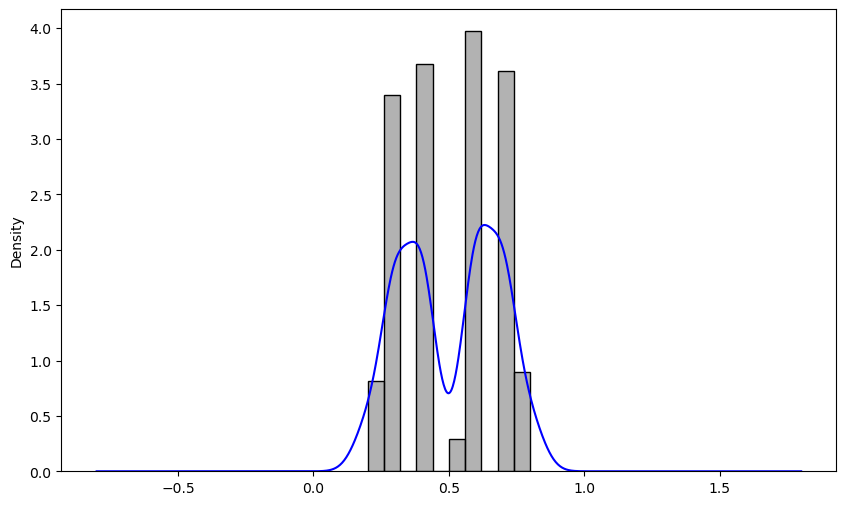

In [109]:
# Example dictionary with continuous values assigned to categorical variables
data = {'A': 0.0, 'B': 0.1, 'C': 0.2, 'D': 0.3, 'E': 0.4, 'F': 0.5, 'G': 0.6, 'H': 0.7, 'I': 0.8, 'J': 0.9, 'K': 1.0}

# Example frequencies for each category (can be changed to actual frequencies)
frequencies = candidate_win_distribution

# Expand the data according to the frequencies
expanded_data = []
for category, freq in frequencies.items():
    expanded_data.extend([data[category]] * freq)

kde = gaussian_kde(expanded_data, bw_method=0.3)

# Create an array of values for the x-axis
x = np.linspace(min(expanded_data) - 1, max(expanded_data) + 1, 1000)
kde_values = kde(x)

# Plot the histogram and KDE
plt.figure(figsize=(10, 6))
sns.histplot(expanded_data, kde=False, stat="density", alpha=0.6, color="gray", bins=10)
plt.plot(x, kde_values, color='blue')

In [134]:
def kdeBallotSampler(kde):
    numberBallots = 10000
    resampled_data = kde.resample(size=numberBallots).flatten()
    candidates = {'A': 0.0, 'B': 0.1, 'C': 0.2, 'D': 0.3, 'E': 0.4, 'F': 0.5, 'G': 0.6, 'H': 0.7, 'I': 0.8, 'J': 0.9, 'K': 1.0}

    distances = {}

    for i in range(numberBallots):
        dist_to_other_points = {}
        for candidate in candidates:
            dist_to_other_points[candidate] = abs(resampled_data[i] - candidates[candidate])
        dist_to_other_points = distances_to_probabilities(dist_to_other_points, temperature)
        distances[i] = dist_to_other_points

    # For now sample uniformly from a length

    lengths = np.random.rand(numberBallots,1)
    dict_ballot = {}

    for i in range(numberBallots):
        dict_ballot[i] = simulateBallot(distances[i], 5)

    profile = PreferenceProfile(ballots = [dict_ballot[ballot] for ballot in dict_ballot], candidates = list(candidates.keys()))
    condensed_profile  = profile.condense_ballots()
    return condensed_profile

In [121]:
profile = kdeBallotSampler(kde)

In [122]:
print(profile)

PreferenceProfile too long, only showing 15 out of 4848 rows.
        Ballots Weight
(I, J, H, K, G)     32
(I, J, K, H, G)     28
(I, K, J, H, G)     26
(H, I, J, K, G)     26
(B, C, D, A, E)     23
(B, C, D, E, A)     23
(H, I, G, J, K)     22
(C, B, D, A, E)     22
(B, D, C, E, A)     21
(J, I, G, H, K)     20
(I, H, K, J, G)     20
(C, B, A, D, E)     20
(J, H, K, I, G)     19
(I, J, G, H, K)     19
(B, C, A, E, D)     19


In [123]:
epoch = 2000
candidate_win_distribution_epoch2 = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'J': 0, 'K': 0}
for _ in range(epoch):
    if _ % 10 == 0:
        print(f"Finished run {_}")
    profile = kdeBallotSampler(kde)
    electionIRV = IRV(profile = profile)
    state = electionIRV.run_election()
    candidate_win_distribution_epoch2[next(iter(state.winners()[0]))] += 1

Finished run 0
Finished run 10
Finished run 20
Finished run 30
Finished run 40
Finished run 50
Finished run 60
Finished run 70
Finished run 80
Finished run 90
Finished run 100
Finished run 110
Finished run 120
Finished run 130
Finished run 140
Finished run 150
Finished run 160
Finished run 170
Finished run 180
Finished run 190
Finished run 200
Finished run 210
Finished run 220
Finished run 230
Finished run 240
Finished run 250
Finished run 260
Finished run 270
Finished run 280
Finished run 290
Finished run 300
Finished run 310
Finished run 320
Finished run 330
Finished run 340
Finished run 350
Finished run 360
Finished run 370
Finished run 380
Finished run 390
Finished run 400
Finished run 410
Finished run 420
Finished run 430
Finished run 440
Finished run 450
Finished run 460
Finished run 470
Finished run 480
Finished run 490
Finished run 500
Finished run 510
Finished run 520
Finished run 530
Finished run 540
Finished run 550
Finished run 560
Finished run 570
Finished run 580
Finished

In [127]:
candidate_win_distribution_epoch2

{'A': 0,
 'B': 0,
 'C': 284,
 'D': 0,
 'E': 0,
 'F': 0,
 'G': 0,
 'H': 0,
 'I': 1716,
 'J': 0,
 'K': 0}

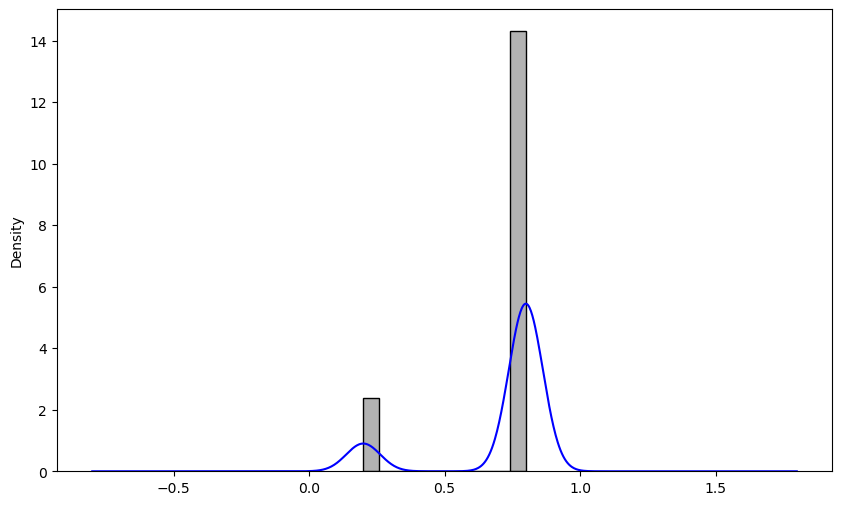

In [126]:
# Example dictionary with continuous values assigned to categorical variables
data = {'A': 0.0, 'B': 0.1, 'C': 0.2, 'D': 0.3, 'E': 0.4, 'F': 0.5, 'G': 0.6, 'H': 0.7, 'I': 0.8, 'J': 0.9, 'K': 1.0}

# Example frequencies for each category (can be changed to actual frequencies)
frequencies = candidate_win_distribution_epoch2

# Expand the data acncording to the frequencies
expanded_data = []
for category, freq in frequencies.items():
    expanded_data.extend([data[category]] * freq)

kde = gaussian_kde(expanded_data, bw_method=0.3)

# Create an array of values for the x-axis
x = np.linspace(min(expanded_data) - 1, max(expanded_data) + 1, 1000)
kde_values = kde(x)

# Plot the histogram and KDE
plt.figure(figsize=(10, 6))
sns.histplot(expanded_data, kde=False, stat="density", alpha=0.6, color="gray", bins=10)
plt.plot(x, kde_values, color='blue')

In [128]:
epoch = 2000
candidate_win_distribution_epoch3 = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'J': 0, 'K': 0}
for _ in range(epoch):
    if _ % 10 == 0:
        print(f"Finished run {_}")
    profile = kdeBallotSampler(kde)
    electionIRV = IRV(profile = profile)
    state = electionIRV.run_election()
    candidate_win_distribution_epoch3[next(iter(state.winners()[0]))] += 1

Finished run 0
Finished run 10
Finished run 20
Finished run 30
Finished run 40
Finished run 50
Finished run 60
Finished run 70
Finished run 80
Finished run 90
Finished run 100
Finished run 110
Finished run 120
Finished run 130
Finished run 140
Finished run 150
Finished run 160
Finished run 170
Finished run 180
Finished run 190
Finished run 200
Finished run 210
Finished run 220
Finished run 230
Finished run 240
Finished run 250
Finished run 260
Finished run 270
Finished run 280
Finished run 290
Finished run 300
Finished run 310
Finished run 320
Finished run 330
Finished run 340
Finished run 350
Finished run 360
Finished run 370
Finished run 380
Finished run 390
Finished run 400
Finished run 410
Finished run 420
Finished run 430
Finished run 440
Finished run 450
Finished run 460
Finished run 470
Finished run 480
Finished run 490
Finished run 500
Finished run 510
Finished run 520
Finished run 530
Finished run 540
Finished run 550
Finished run 560
Finished run 570
Finished run 580
Finished

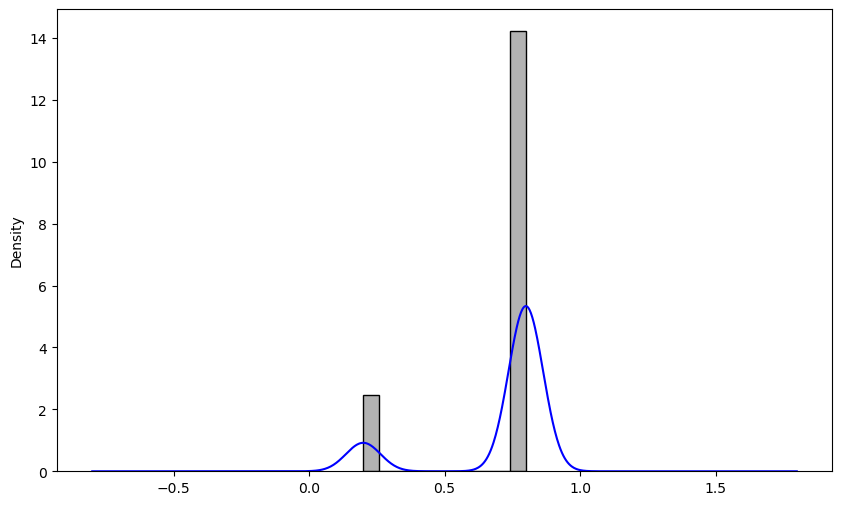

In [129]:
# Example dictionary with continuous values assigned to categorical variables
data = {'A': 0.0, 'B': 0.1, 'C': 0.2, 'D': 0.3, 'E': 0.4, 'F': 0.5, 'G': 0.6, 'H': 0.7, 'I': 0.8, 'J': 0.9, 'K': 1.0}

# Example frequencies for each category (can be changed to actual frequencies)
frequencies = candidate_win_distribution_epoch3

# Expand the data acncording to the frequencies
expanded_data = []
for category, freq in frequencies.items():
    expanded_data.extend([data[category]] * freq)

kde = gaussian_kde(expanded_data, bw_method=0.3)

# Create an array of values for the x-axis
x = np.linspace(min(expanded_data) - 1, max(expanded_data) + 1, 1000)
kde_values = kde(x)

# Plot the histogram and KDE
plt.figure(figsize=(10, 6))
sns.histplot(expanded_data, kde=False, stat="density", alpha=0.6, color="gray", bins=10)
plt.plot(x, kde_values, color='blue')

In [130]:
epoch = 2000
candidate_win_distribution_epoch4 = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'J': 0, 'K': 0}
for _ in range(epoch):
    if _ % 10 == 0:
        print(f"Finished run {_}")
    profile = kdeBallotSampler(kde)
    electionIRV = IRV(profile = profile)
    state = electionIRV.run_election()
    candidate_win_distribution_epoch4[next(iter(state.winners()[0]))] += 1

Finished run 0
Finished run 10
Finished run 20
Finished run 30
Finished run 40
Finished run 50
Finished run 60
Finished run 70
Finished run 80
Finished run 90
Finished run 100
Finished run 110
Finished run 120
Finished run 130
Finished run 140
Finished run 150
Finished run 160
Finished run 170
Finished run 180
Finished run 190
Finished run 200
Finished run 210
Finished run 220
Finished run 230
Finished run 240
Finished run 250
Finished run 260
Finished run 270
Finished run 280
Finished run 290
Finished run 300
Finished run 310
Finished run 320
Finished run 330
Finished run 340
Finished run 350
Finished run 360
Finished run 370
Finished run 380
Finished run 390
Finished run 400
Finished run 410
Finished run 420
Finished run 430
Finished run 440
Finished run 450
Finished run 460
Finished run 470
Finished run 480
Finished run 490
Finished run 500
Finished run 510
Finished run 520
Finished run 530
Finished run 540
Finished run 550
Finished run 560
Finished run 570
Finished run 580
Finished

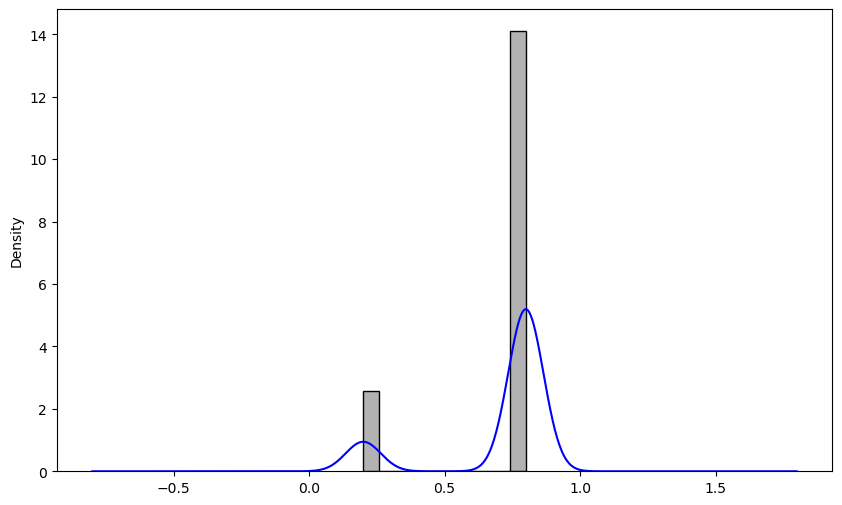

In [132]:
# Example dictionary with continuous values assigned to categorical variables
data = {'A': 0.0, 'B': 0.1, 'C': 0.2, 'D': 0.3, 'E': 0.4, 'F': 0.5, 'G': 0.6, 'H': 0.7, 'I': 0.8, 'J': 0.9, 'K': 1.0}

# Example frequencies for each category (can be changed to actual frequencies)
frequencies = candidate_win_distribution_epoch4

# Expand the data acncording to the frequencies
expanded_data = []
for category, freq in frequencies.items():
    expanded_data.extend([data[category]] * freq)

kde = gaussian_kde(expanded_data, bw_method=0.3)

# Create an array of values for the x-axis
x = np.linspace(min(expanded_data) - 1, max(expanded_data) + 1, 1000)
kde_values = kde(x)

# Plot the histogram and KDE
plt.figure(figsize=(10, 6))
sns.histplot(expanded_data, kde=False, stat="density", alpha=0.6, color="gray", bins=10)
plt.plot(x, kde_values, color='blue')

Finished run 0
Finished run 10
Finished run 20
Finished run 30
Finished run 40
Finished run 50
Finished run 60
Finished run 70
Finished run 80
Finished run 90
Finished run 100


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x11183b1c0>>
Traceback (most recent call last):
  File "/Users/ppeaungvongpakdy/opt/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Finished run 110
Finished run 120
Finished run 130
Finished run 140
Finished run 150
Finished run 160
Finished run 170
Finished run 180
Finished run 190
Finished run 200
Finished run 210
Finished run 220
Finished run 230
Finished run 240
Finished run 250
Finished run 260
Finished run 270
Finished run 280
Finished run 290
Finished run 300
Finished run 310
Finished run 320
Finished run 330
Finished run 340
Finished run 350
Finished run 360
Finished run 370
Finished run 380
Finished run 390
Finished run 400
Finished run 410
Finished run 420
Finished run 430
Finished run 440
Finished run 450
Finished run 460
Finished run 470
Finished run 480
Finished run 490
Finished run 500
Finished run 510
Finished run 520
Finished run 530
Finished run 540
Finished run 550
Finished run 560
Finished run 570
Finished run 580
Finished run 590
Finished run 600
Finished run 610
Finished run 620
Finished run 630
Finished run 640
Finished run 650
Finished run 660
Finished run 670
Finished run 680
Finished run 6

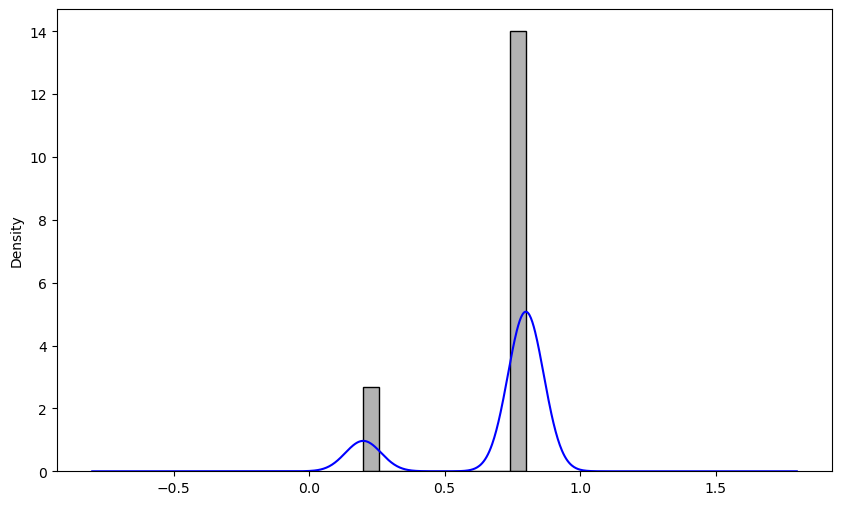

In [133]:
epoch = 2000
candidate_win_distribution_epoch5 = {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'J': 0, 'K': 0}
for _ in range(epoch):
    if _ % 10 == 0:
        print(f"Finished run {_}")
    profile = kdeBallotSampler(kde)
    electionIRV = IRV(profile = profile)
    state = electionIRV.run_election()
    candidate_win_distribution_epoch5[next(iter(state.winners()[0]))] += 1

# Example dictionary with continuous values assigned to categorical variables
data = {'A': 0.0, 'B': 0.1, 'C': 0.2, 'D': 0.3, 'E': 0.4, 'F': 0.5, 'G': 0.6, 'H': 0.7, 'I': 0.8, 'J': 0.9, 'K': 1.0}

# Example frequencies for each category (can be changed to actual frequencies)
frequencies = candidate_win_distribution_epoch5

# Expand the data acncording to the frequencies
expanded_data = []
for category, freq in frequencies.items():
    expanded_data.extend([data[category]] * freq)

kde = gaussian_kde(expanded_data, bw_method=0.3)

# Create an array of values for the x-axis
x = np.linspace(min(expanded_data) - 1, max(expanded_data) + 1, 1000)
kde_values = kde(x)

# Plot the histogram and KDE
plt.figure(figsize=(10, 6))
sns.histplot(expanded_data, kde=False, stat="density", alpha=0.6, color="gray", bins=10)
plt.plot(x, kde_values, color='blue')